### Group Members

**Ojo, Oluwaseun** | **Sholola, Oluwafunmiwo Judah**

### Context of Dataset and Goal Overview

For our dataset, we settled on automotive data from MarketCheck spanning 8 years of inventory in Canada. Each record indicates the most recent online activity for a particular vehicle, obtained via webcrawlers that aggregate info retrieved from a vast number (~65k) of dealer websites. Online activity is not defined, but it is reasonably safe (based on the 'price' attribute provided) to assume that the records indicate sale listings (and not leases, or rentals).

According to the dataset's [Kaggle link](https://www.kaggle.com/datasets/3ea0a6a45dbd4713a8759988845f1a58038036d84515ded58f65a2ff2bd32e00?resource=download), it was last updated a year ago, so we can reasonably expect 2021 to be the upper limit for the year of car manufacture.

This dataset comprises some expected attributes such as the price, make, mileage and manufacturing year of the car. It also includes more specific (and potentially more interesting) attributes such as the fuel type, the engine size, the (corporate) dealer name and site of activity (zip and province).

While our exact goal is not settled upon just yet, as we have not studied the data in-depth enough to hone in on a single phenom, listed below are a few possible phenomenon that are in contention to be studied by us in future iterations:

* correlation of price to the make and year of a vehicle
* correlation of vehicle fuel type to sales (or frequency of sales, more specifically)
* the ideal car (or kind of car) to buy based on the age of vehicles
* the ideal province to buy a used car within Canada taking price and mileage into consideration

That said, let us dive in!


### Exploring the Data...

Prior to importing our dataset, we quickly observe that the total number of records in the dataset and the number of unique VIN values **DO NOT** match. 

The reason for this disparity in the number of records and the VIN's is due to the fact that certain 
cars come up for sale multiple times within the collection window of the dataset (the past year), or they come multiple different dealer sites.

<img src="img\kaggle-id-vin.png" width="600" height="300">






In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('ca-dealers-used.csv')

# confirming what we observe at a glance on Kaggle
df['vin'].describe()

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/2541389031.py:5: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ca-dealers-used.csv')


count                393603
unique               226691
top       5LMJJ2JT1KEL20643
freq                     21
Name: vin, dtype: object

### Index selection

Logically, it makes sense to use either the **id** attribute (which is unique) or the **vin** attribute (which, ideally, would be unique in the dataset).

Since some VIN's pop up a few times in the dataset as a result of certain vehicles being traded multiple times, we have to decide:
* if we want to drop duplicate VIN's and simply represent each vehicle once throughout the dataframe, thus making the **vin** attribute unique and possible for use as the **index** of the dataframe; *or*
* if we want to keep multiple instances of a vehicle in the dataframe and utilize **id** as a single index, or **(id, vin)** as a MultiIndex **index** of the dataframe

We decided to drop rows with duplicate VIN's as we do not require multiple instances of a vehicle for the purposes of our analysis. Subsequently, we set **id** attribute as our index.



In [66]:
# drop rows with duplicate VIN and set 'id' as our index
df_copy = df.copy()
df_copy = df_copy.drop_duplicates('vin')
df_copy = df_copy.reset_index(drop=True).set_index('id')

display(df_copy)

,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
id,,,,,,,,,,,,,,,,,,,,
b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
0487af07-893c,19UNC1B03HY800063,155771.0,18281.0,U02856,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,gravel auto crdit,102-1007 Boulevard Ren Lvesque Verdun,Montral,QC,H3E 0H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a02fbcbc-9f63,WDC0G5EB7JV034017,43900.0,68665.0,E-0069,2018.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,Truck,4WD,Automatic,Electric / Unleaded,2.0,I,hyundai repentigny,845 Rue Notre Dame,Repentigny,QC,J5Y 1C4
f71c5738-33d8,WDC0G5EB8KF614677,47995.0,22108.0,M0684,2019.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,Truck,4WD,Automatic,Electric / Unleaded,2.0,I,mercedes-benz granby,1225 Rue Principale,Granby,QC,J2J 0M3
873d76f0-18d2,WDC0G5EB9JF465808,42995.0,55316.0,D13339,2018.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,Truck,4WD,Automatic,Electric / Unleaded,2.0,I,groupe park avenue - regroupement automobile,8840 Boulevard Taschereau,Brossard,QC,J4X 1C2


In [67]:
# getting a basic, high-level overview
display(df_copy.info())

# general description of numerical attributes in dataset
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 226691 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           226691 non-null  object 
 1   price         203832 non-null  float64
 2   miles         214003 non-null  float64
 3   stock_no      210828 non-null  object 
 4   year          226678 non-null  float64
 5   make          226691 non-null  object 
 6   model         223824 non-null  object 
 7   trim          199775 non-null  object 
 8   body_type     206027 non-null  object 
 9   vehicle_type  203775 non-null  object 
 10  drivetrain    200702 non-null  object 
 11  transmission  201979 non-null  object 
 12  fuel_type     181432 non-null  object 
 13  engine_size   180550 non-null  float64
 14  engine_block  180131 non-null  object 
 15  seller_name   225486 non-null  object 
 16  street        222762 non-null  object 
 17  city          222865 non-null  obj

None

,price,miles,year,engine_size
count,2.038320e+05,2.140030e+05,226678.000000,180550.000000
mean,2.541799e+04,7.999847e+04,2016.020972,2.784155
std,2.128191e+04,6.075388e+04,3.609585,1.229094
min,0.000000e+00,0.000000e+00,1981.000000,0.600000
25%,1.399500e+04,3.657100e+04,2014.000000,2.000000
50%,2.099500e+04,6.643900e+04,2017.000000,2.400000
75%,3.149500e+04,1.120000e+05,2018.000000,3.500000
max,1.288888e+06,2.300033e+06,2022.000000,8.400000


### Justification for dropping certain columns

The decision to drop these columns is moreso based on some domain knowledge and logic.

The **stock_no** attribute is unique to each dealer's online inventory categorization system, and is not of a singular format; some are purely numeric in nature, while some are alphanumeric. As such, it is not extremely useful across diverse sources (dealers).

In [6]:
# display first 20 'stock_no' fields
display(df_copy['stock_no'].head(20))

id
b39ea795-eca9         V-P4139
026cb5b1-6e3e       PPAP70374
5cd5d5b2-5cc2          B21085
b32473ed-5922          AP5333
0487af07-893c          U02856
e39410c3-ef41         UC6386A
19549afd-1a64          200404
9bff56cb-9e20            CONS
e190cc9a-1062           P7172
031632fa-66c6    2017NSXWHITE
79d4a6a9-c265          MU2483
a7b53aaa-ae99             NaN
acdf10ba-fa76          215140
3ec82d01-aec0           30479
19cab0ff-35f0         KH6268B
d128f381-0f23     2008DAVGWHT
bcd6cd07-d086           95169
b241c836-6a57             NaN
6a88647d-ff1a        11024-21
072f8e65-1a4e       2M060(59)
Name: stock_no, dtype: object

We decided to drop the **trim** attribute because of the sheer number of unique values it contains per **make**. It could lead to feature explosion.

In [51]:
display(df_copy.groupby('trim')['make'].describe())
display(sum(df_copy.groupby('trim')['make'].describe()['unique']))

display(df_copy.groupby('make')['trim'].describe())
display(sum(df_copy.groupby('make')['trim'].describe()['unique']))

,count,unique,top,freq
trim,,,,
+,115,11,Kia,74
- MT,1,1,Mazda,1
.3,1,1,Mercedes-Benz,1
1,14,7,Honda,5
1.6 S,2,1,Nissan,2
...,...,...,...,...
xDrive35i Premium,6,1,BMW,6
xDrive35i Sport Activity,1,1,BMW,1
xDrive40e,22,1,BMW,22


2705

,count,unique,top,freq
make,,,,
Acura,2670,62,Base,620
Alfa Romeo,138,7,Base,39
Am General,9,3,Base,5
Aston Martin,52,6,Base,43
Audi,4398,106,Premium,1182
BMW,8198,129,28i,1293
Bentley,100,6,Base,75
Buick,2355,53,Preferred,427
Cadillac,1418,35,Luxury,518


2705

The **engine_block** is a low-level attribute that has **3** possible values:
* H-engine type
* I-engine type
* V-engine type

It is not a particularly desirable attribute for our purposes. 

Also, unlike some other attributes such as the manufacturing **year**, which can be decoded from the **VIN** and are uniform/standard across various vehicle manufacturers, the **engine_block** code in the VIN differs across manufacturers (**make**) and even across **models** within the same make. 

As such, it rapidly devolves into an arduous task in trying to retrieve an attribute that we, once again, do not view as useful to our goal(s).

In [8]:
display(df_copy.groupby('engine_block').count())

df_copy['engine_block'].describe()

,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,seller_name,street,city,state,zip
engine_block,,,,,,,,,,,,,,,,,,,
H,2541,2235,2432,2369,2541,2541,2541,2541,2541,2540,2489,2488,2445,2541,2520,2507,2506,2507,2507
I,113164,103934,107422,106145,113164,113164,113164,113164,113164,113164,113164,113164,113164,113164,112545,111264,111312,111300,111313
V,64426,57186,60173,60437,64426,64426,64426,64426,64416,64418,64339,64336,64299,64426,64084,63114,63180,63170,63179


count     180131
unique         3
top            I
freq      113164
Name: engine_block, dtype: object

The **street** and **zip** attributes are being dropped in favour of 2 other geo-based attributes, **city** and **state**.

#### Proceeding to drop the unwanted columns and reordering our retained columns

In [68]:
# specify the columns and drop them
col_to_drop = ['stock_no', 'trim', 'engine_block', 'street', 'zip']
df_copy = df_copy.drop(columns=col_to_drop)

# specify an order of columns and order them accordingly
order_of_cols = ['vin', 'make', 'model', 'year','miles', 'price', 'fuel_type', 'engine_size', 'body_type',  'vehicle_type', 'transmission', 'drivetrain', 'seller_name', 'city', 'state']
df_copy = df_copy[order_of_cols]

# rename state to province (more appropriate to Canada)
df_copy.rename(columns={'state' : 'province'}, inplace=True)

df_copy


,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province
id,,,,,,,,,,,,,,,
b39ea795-eca9,19UNC1B01HY800062,Acura,NSX,2017.0,9966.0,179999.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,edmundston honda,Edmundston,NB
026cb5b1-6e3e,19UNC1B02HY800023,Acura,NSX,2017.0,5988.0,179995.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,garage daniel lessard,Notre-dame-des-pins,QC
5cd5d5b2-5cc2,19UNC1B02HY800071,Acura,NSX,2017.0,24242.0,168528.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,lougheed acura,Coquitlam,BC
b32473ed-5922,19UNC1B02LY800001,Acura,NSX,2020.0,6637.0,220000.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,drive autogroup,Pickering,ON
0487af07-893c,19UNC1B03HY800063,Acura,NSX,2017.0,18281.0,155771.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,gravel auto crdit,Montral,QC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a02fbcbc-9f63,WDC0G5EB7JV034017,Mercedes-Benz,GLC-Class,2018.0,68665.0,43900.0,Electric / Unleaded,2.0,SUV,Truck,Automatic,4WD,hyundai repentigny,Repentigny,QC
f71c5738-33d8,WDC0G5EB8KF614677,Mercedes-Benz,GLC-Class,2019.0,22108.0,47995.0,Electric / Unleaded,2.0,SUV,Truck,Automatic,4WD,mercedes-benz granby,Granby,QC
873d76f0-18d2,WDC0G5EB9JF465808,Mercedes-Benz,GLC-Class,2018.0,55316.0,42995.0,Electric / Unleaded,2.0,SUV,Truck,Automatic,4WD,groupe park avenue - regroupement automobile,Brossard,QC


### Inclusion of an Additional (Derived) Column

We decided to derive a new column, **age**, based off the manufacturing **year**, which we use to prune off vehicles that fall outside a specific range. It is important to note that this is not a trimming off of outliers, rather we are choosing deal *only* with cars that were manufactured *more recently*.

This attribute might also come in handy in extracting useful features, such as the relationship between the manufacturing **year** of vehicles and the **frequency** (number) of sales.

Ages Before
Oldest: 41.0
Newest: 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 226691 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           226691 non-null  object 
 1   make          226691 non-null  object 
 2   model         223824 non-null  object 
 3   year          226678 non-null  float64
 4   miles         214003 non-null  float64
 5   price         203832 non-null  float64
 6   fuel_type     181432 non-null  object 
 7   engine_size   180550 non-null  float64
 8   body_type     206027 non-null  object 
 9   vehicle_type  203775 non-null  object 
 10  transmission  201979 non-null  object 
 11  drivetrain    200702 non-null  object 
 12  seller_name   225486 non-null  object 
 13  city          222865 non-null  object 
 14  province      222802 non-null  object 
 15  age           226678 non-null  float64
dtypes: float64(5), object(11)
memory usage: 2

None

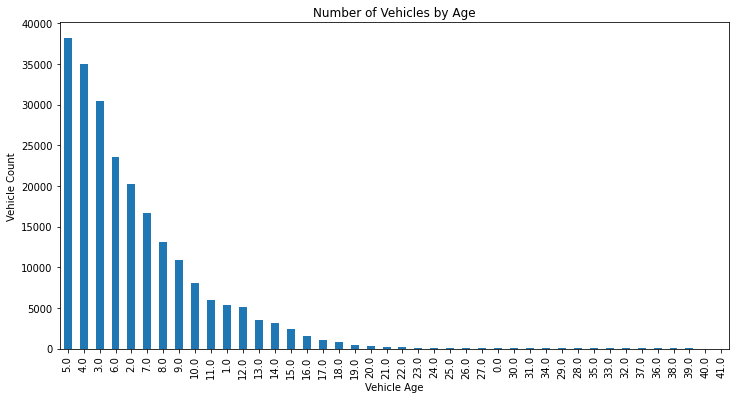

In [69]:
df_copy['age'] = df_copy.year.apply(lambda x: 2022-x) # creating age column to know the age of the vehicles in our dataset
print(f"Ages Before\nOldest: {df_copy['age'].max()}\nNewest: {df_copy['age'].min()}")
display(df_copy.info())

# """We will plot a line plot to see the number of vehicles by age in order to know if we should keep or drop
# rows based on the age of the vehicle"""

#Plotting the numbers of vehicles by year
df_copy['age'].value_counts().plot(kind='bar', figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()

Ages After
Oldest: 15.0
Newest: 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          221742 non-null  float64
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   fuel_type     178168 non-null  object 
 7   engine_size   177244 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199542 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  province      217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(5), object(11)
memory usage: 28

None

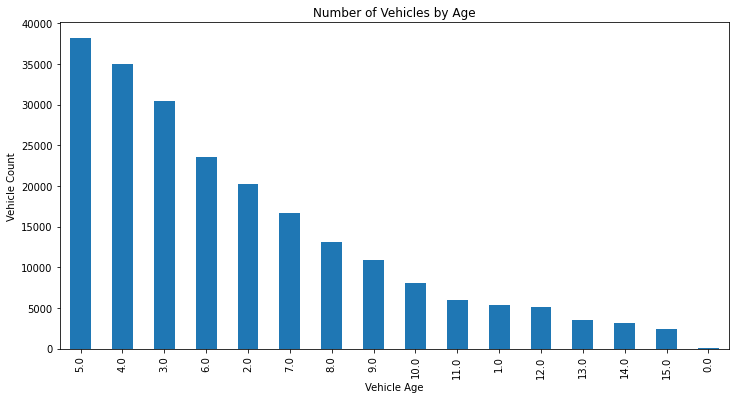

In [70]:
"""
From our plot, we can observe that the vehicles that are newer have higher numbers than older vehicles.
We will therefore drop rows with older cars. We will work with cars between ages 1 - 15
"""

df_copy = df_copy[(df_copy['age']>= 0) & (df_copy['age'] <= 15)] # removing vehicles that are older than 20 years old
print(f"Ages After\nOldest: {df_copy['age'].max()}\nNewest: {df_copy['age'].min()}")
display(df_copy.info())

#Plotting the numbers of vehicles by year after removi g older cars
df_copy['age'].value_counts().plot(kind='bar',figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()

### Contextualization and Description of Variables

Our dataset is the collection of inventory of used cars from various auto dealers across Canada. The data depicts the market activity of used cars sold by different dealers in the various provinces of Canada. The following are the variables in the dataset and their description:

**id** :    Unique identifier for each row.<br>
            *Data type: string*<br>
**vin** :   17 character long vehicle identification number. This is the value that uniquely identify each vehicle.<br> 
            *Data type: string* <br>
**price** : Price of the vehicle. This is the value that we will try to predict.<br>
            *Data type: float* <br>
**miles** : Number of miles/odometer on the vehicle. The higher the number, the more the vehicle has been driven or used.<br>
            *Data type: float* <br>
**year** :  Model year of the vehicle - Decoded from VIN. This is the year the vehicle was manufactured. <br>
            *Data type: float* <br>
**make** :  Make of the vehicle - Decoded from VIN. This is the manufacturer of the vehicle. <br>
            *Data type: string* <br>
**model** : Model of the vehicle - Decoded from VIN. It is the specific model of the vehicle. <br>
            *Data type: string* <br>
**body_type** : Body type of the vehicle - Decoded from VIN. This is the type of vehicle. For example, sedan, coupe, SUV, etc. <br>
            *Data type: string* <br>
**vehicle_type** : This is the type of vehicle. For example, car, truck, etc. <br>
            *Data type: string* <br>
**engine_size** : This is the size of the engine in liters. <br>
            *Data type: float*<br>
**fuel_type** : This is the type of fuel the vehicle uses. For example, gasoline, diesel, etc. <br>
            *Data type: string* <br>
**transmission** : Transmission type of the vehicle. The transmission type is either automatic or manual. <br>
            *Data type: string* <br>
**drivetrain** : Drivetrain type of the vehicle. The drivetrain type is either 4WD, FWD, or RWD. <br>
            *Data type: string* <br>
**seller_name** : Name of the seller or dealership. <br>
            *Data type: string* <br>
**city** : City of the seller or dealership. <br>
            *Data type: string* <br>
**state** : State of the seller or dealership. <br>
            *Data type: string* <br>



### Filling in Missing Data
Two attributes we decided on, for addressing missing data are:
* **year**; *and*
* **engine_size**

For **year**, it is **not** missing from the original dataset, so we are going to artificially introduce missing values in some rows. The intention (and result) is to repoduce these values by decoding the VIN. It is a standard across all manufacturers that the **10th digit** in the VIN is a *letter* or a *number*, which corresponds to the manufacturing year of the vehicle.

<img src="img\vin-year-dict-mapping.png" width="600" height="300">



In [71]:
# function to introduce NaN into random rows under a particular column
def add_NaN_random_rows(data, attribute, fraction):
    for col in data.columns:
        if col == attribute:
            data.loc[data.sample(frac=fraction).index, col] = np.nan

# place/introduce NaN into year for a random sample of 20% of our dataset,
# effectively mimicking missing data under the 'year' attribute 
add_NaN_random_rows(df_copy, 'year', 0.2) 
display(df_copy.info())
missing_year = df_copy[df_copy['year'].isnull()]
display(missing_year.info())

<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          177394 non-null  float64
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   fuel_type     178168 non-null  object 
 7   engine_size   177244 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199542 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  province      217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(5), object(11)
memory usage: 36.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 44348 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           44348 non-null  object 
 1   make          44348 non-null  object 
 2   model         43848 non-null  object 
 3   year          0 non-null      float64
 4   miles         41897 non-null  float64
 5   price         40060 non-null  float64
 6   fuel_type     35687 non-null  object 
 7   engine_size   35509 non-null  float64
 8   body_type     40438 non-null  object 
 9   vehicle_type  40021 non-null  object 
 10  transmission  39539 non-null  object 
 11  drivetrain    39321 non-null  object 
 12  seller_name   44113 non-null  object 
 13  city          43591 non-null  object 
 14  province      43584 non-null  object 
 15  age           44348 non-null  float64
dtypes: float64(5), object(11)
memory usage: 5.8+ MB


None

In [72]:
"""
We are able to fill missing year from Vehicle VIN.
This function generates year of the vehicle from the VIN.
"""

def generate_year(vin):
    decoder = {'1':'2001', '2': '2002', '3': '2003', '4':'2004', '5':'2005', '6':'2006', '7':'2007', '8':'2008', '9':'2009', 'A':'2010', 'B':'2011', 
               'C':'2012', 'D':'2013', 'E':'2014', 'F':'2015', 'G':'2016', 'H':'2017', 'J':'2018', 'K':'2019', 'L':'2020', 'M':'2021', 'N':'2022'}
    vin = str(vin)
    if (len(vin) != 17) :
        return
    else:
        year_code = str(vin)[-8]
        
        for key,value in decoder.items():
            if year_code == key:
                return value      
    
df_copy['year'] = df_copy['vin'].apply(generate_year)
df_copy.sort_values(by=['year'], ascending=False)
df_copy.info()

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/1599588208.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['year'] = df_copy['vin'].apply(generate_year)


<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          221742 non-null  object 
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   fuel_type     178168 non-null  object 
 7   engine_size   177244 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199542 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  province      217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(4), object(12)
memory usage: 36.8+ MB


For **engine_size**, about **18%** of values are missing from this attribute in the original dataset. The engine size can be derived from the VIN, but the encoding is unique to each manufacturer and also to the particular model of a vehicle, so using a dictionary would be expensive (memory-wise). As such, we utilize centrality measures, based on categorization fo a related column (**body_type**), to fill missing values.

,count,unique,top,freq
engine_size,,,,
0.6,15,1,Hatchback,15
0.9,93,2,Micro Car,92
1.0,266,6,SUV,96
1.2,313,3,Hatchback,283
1.3,87,5,SUV,42
1.4,7660,7,Sedan,3847
1.5,9534,7,SUV,5455
1.6,6832,9,Hatchback,3417
1.7,7,2,Coupe,4


,std,min,mean,max,median,mode
body_type,,,,,,
Car Van,0.246272,1.6,2.282677,2.5,2.40,2.5
Cargo Van,1.169791,2.0,3.804326,6.8,3.70,2.0
Chassis Cab,1.036042,2.1,6.153846,7.3,6.60,6.7
Combi,0.259580,2.0,2.213043,3.0,2.00,2.0
Commercial Wagon,NaN,1.6,1.600000,1.6,1.60,1.6
Convertible,1.480801,1.0,3.504653,8.4,3.00,3.0
Coupe,1.464191,0.9,3.305602,8.4,3.00,2.0
Crossover,0.714108,1.6,2.730769,3.7,2.60,3.5
Cutaway,0.962259,3.2,5.877907,7.3,6.00,6.0


<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          221742 non-null  object 
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   fuel_type     178168 non-null  object 
 7   engine_size   177244 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199542 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  province      217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(4), object(12)
memory usage: 36.8+ MB


None

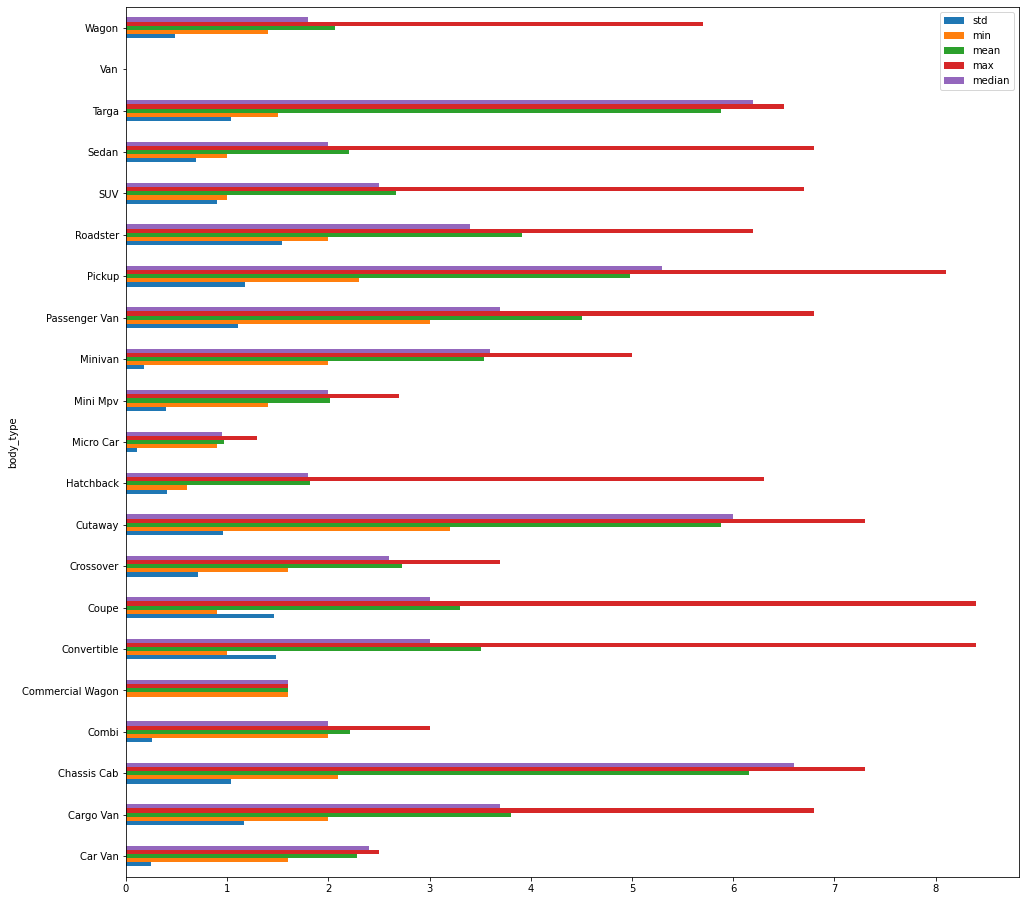

In [73]:
# engine_size per body_type category
display(df_copy.groupby('engine_size')['body_type'].describe())

# engine_size stats based on body_type of vehicles
engine_size_stats = df_copy.groupby('body_type')['engine_size'].agg({'mean', 'median', pd.Series.mode, 'std', 'min', 'max'})
engine_size_stats = engine_size_stats[['std', 'min', 'mean', 'max', 'median', 'mode']]
display(engine_size_stats)

fig, axs = plt.subplots(1, 1, figsize=(16,16))
engine_size_stats.plot.barh(ax=axs)

# all vehicles with 'Van' body_type are missing 'engine_size' attribute
# display(df_copy[df_copy['body_type'] == 'Van']['engine_size'].info())

display(df_copy.info())

In [74]:
# remove rows with NaN in body_type attr; can't derive a reasonable engine_size heuristic for them
# this is really important;
df_copy.dropna(subset=['body_type'], inplace=True)

# we save a record of rows that are currently missing their engine_size (but do not have NaN as body_type (already dropped those above))
# this way, we can compare our method of filling (using measures of centrality)
# to some engine_size values derived using some model (if we do go down that route)
engine_size_missing = df_copy[df_copy['engine_size'].isna()]
display(engine_size_missing)   

# returns some centrality measure (mean or median) of observed 'engine_sizes' for a vehicle of a certain 'body_type'
def fix_engine_size(body_type) :
    # print(engine_size_stats.loc[val, 'mean'])
    return engine_size_stats.loc[body_type, 'mean']

# replace missing engine_size with a specified mean
df_copy['engine_size'].fillna(df_copy[df_copy['engine_size'].isna()]['body_type'].apply(fix_engine_size), inplace=True)

# should be left with rows (vehicles) with no centrality values for their body_type (NaN for mean of Vans for instance)
display(df_copy[df_copy['engine_size'].isna()])

#saving rows with missing price
price_missing = df_copy[df_copy['price'].isna()]
display(price_missing)                      


C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/1288481990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.dropna(subset=['body_type'], inplace=True)


,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province,age
id,,,,,,,,,,,,,,,,
d295eb75-3688,1G1RE6E46EU153062,Chevrolet,Volt,2014,145578.0,11975.0,Electric / Premium Unleaded,NaN,Sedan,Car,Automatic,FWD,auto sur commande rive-nord,Saint-joseph-du-lac,QC,8.0
a0dd2860-aac1,JTDBVRBD0HA002013,Toyota,Mirai,2017,49000.0,15900.0,Electric / Hydrogen,NaN,Sedan,Car,Automatic,FWD,lp auto,Richmond,BC,5.0
78af3839-df97,JTDBVRBD2GA000388,Toyota,Mirai,2016,20000.0,21998.0,Electric / Hydrogen,NaN,Sedan,Car,Automatic,FWD,west coast auto group,Pitt Meadows,BC,6.0
835fe8e0-1394,JTDBVRBD9GA000436,Toyota,Mirai,2016,40457.0,14000.0,Electric / Hydrogen,NaN,Sedan,Car,Automatic,FWD,rocky mountain dodge chrysler jeep ram,Rocky Mountain House,AB,6.0
4b77942b-0ce6,JTDBVRBD9GA000582,Toyota,Mirai,2016,36396.0,18700.0,Electric / Hydrogen,NaN,Sedan,Car,Automatic,FWD,i autohaus sales & leasing,Richmond,BC,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98d52f09-3378,2T2BK1BA3DC170035,Lexus,RX,2013,59202.0,NaN,Premium Unleaded,NaN,SUV,Truck,Automatic,4WD,envision auto sales,Calgary,AB,9.0
caec39a0-c733,WDDGJ7HB7DF999686,Mercedes-Benz,C-Class,2013,83849.0,37950.0,Premium Unleaded,NaN,Coupe,Car,Automatic,RWD,automobiles ral parent inc,Qubec,QC,9.0
f8c8f411-8baf,WDDPK6GA2HF135960,Mercedes-Benz,SLC Roadster,2017,6621.0,41800.0,Premium Unleaded,NaN,Roadster,Car,Automatic,RWD,ed autos,Sainte-marie,QC,5.0


C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/1288481990.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['engine_size'].fillna(df_copy[df_copy['engine_size'].isna()]['body_type'].apply(fix_engine_size), inplace=True)


,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province,age
id,,,,,,,,,,,,,,,,
21266f35-9ffb,1FDWE3FP0ADA35645,Ford,Truck,2010,225126.0,18995.0,NaN,NaN,Van,NaN,Automatic,RWD,sk automarket sales ltd,Langley City,BC,12.0
afc2f58b-c74e,1FDXE45P07DA07851,Ford,cube,2007,NaN,13995.0,NaN,NaN,Van,NaN,Automatic,RWD,by pass auto sales,Aldergrove,BC,15.0
34a3df26-c6ab,1FDXE4FSXCDA91898,Ford,cube,2012,91555.0,17900.0,NaN,NaN,Van,NaN,Automatic,RWD,ace automotive,Thunder Bay,ON,10.0
2403359d-86d8,2C4RC1EG3MR509747,Chrysler,Pacifica,2021,3.0,58795.0,NaN,NaN,Van,NaN,Automatic,FWD,towne chrysler,Miramichi,NB,1.0
d65fc599-7a2d,2C4RC1YG2LR282075,Chrysler,Pacifica,2020,540.0,32989.0,NaN,NaN,Van,NaN,Automatic,NaN,lakeridge chrysler,Port Hope,ON,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4b56a435-81c8,NM0LS7V20L1447255,Ford,Transit,2020,4645.0,32985.0,NaN,NaN,Van,NaN,Automatic,FWD,jim pattison lease,Calgary,AB,2.0
1e526678-fd69,NM0LS7V21L1447202,Ford,Transit,2020,8001.0,32985.0,NaN,NaN,Van,NaN,Automatic,FWD,jim pattison lease,Calgary,AB,2.0
5c3c0107-d7e3,NM0LS7V23L1447203,Ford,Transit,2020,6663.0,32985.0,NaN,NaN,Van,NaN,Automatic,FWD,jim pattison lease,Calgary,AB,2.0


,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province,age
id,,,,,,,,,,,,,,,,
79d4a6a9-c265,19UNC1B0XHY800061,Acura,NSX,2017,12864.0,NaN,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,pfaff leasing calgary,Calgary,AB,5.0
bcd6cd07-d086,1B3LC56R98N584325,Dodge,Avenger,2008,239884.0,NaN,E85,2.7,Sedan,Car,Automatic,FWD,financement autos,Laval,QC,14.0
1da10187-32e9,1C6RD7LT2CS134535,RAM,Ram 1500 Pickup,2012,125749.0,NaN,E85 / Unleaded; Unleaded,5.7,Pickup,Truck,Automatic,4WD,rally mazda,Prince Albert,SK,10.0
8cf8f9a0-2107,1D7RV1GT3BS538624,RAM,Ram 1500 Pickup,2011,150042.0,NaN,E85 / Unleaded; Unleaded,5.7,Pickup,Truck,Automatic,4WD,willowbrook used ltd.,Surrey,BC,11.0
d6a3ee38-9da7,1FTEW1E50JFB14092,Ford,F-150,2018,44360.0,NaN,E85 / Unleaded; Unleaded / Unleaded,5.0,Pickup,Truck,Automatic,4WD,drivingit,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88f3a838-903f,KNDCE3LC0J5186343,Kia,Niro,2018,NaN,NaN,Electric / Unleaded,1.6,Hatchback,Car,Automatic,FWD,cariboo truck & auto sales,Quesnel,BC,4.0
4a5ebc94-12dc,KNDCE3LC2J5169317,Kia,Niro,2018,NaN,NaN,Electric / Unleaded,1.6,Hatchback,Car,Automatic,FWD,davewall.ca,Langley City,BC,4.0
1f325253-ba38,KNDCE3LC2K5300666,Kia,Niro,2019,0.0,NaN,Electric / Unleaded,1.6,Hatchback,Car,Automatic,FWD,basant motors,Surrey,BC,3.0


### Handling Outliers
For outliers, we decided to inspect all our numerical attributes, besides **year** and **age**:
* **price**
* **miles**
* **engine_size**

Let's get a preview of our outliers.


<class 'pandas.core.frame.DataFrame'>
Index: 201738 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           201738 non-null  object 
 1   make          201738 non-null  object 
 2   model         201573 non-null  object 
 3   year          201738 non-null  object 
 4   miles         190494 non-null  float64
 5   price         182611 non-null  float64
 6   fuel_type     178155 non-null  object 
 7   engine_size   201585 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199389 non-null  object 
 10  transmission  180525 non-null  object 
 11  drivetrain    180480 non-null  object 
 12  seller_name   200700 non-null  object 
 13  city          198411 non-null  object 
 14  province      198357 non-null  object 
 15  age           201738 non-null  float64
dtypes: float64(4), object(12)
memory usage: 26.2+ MB


None

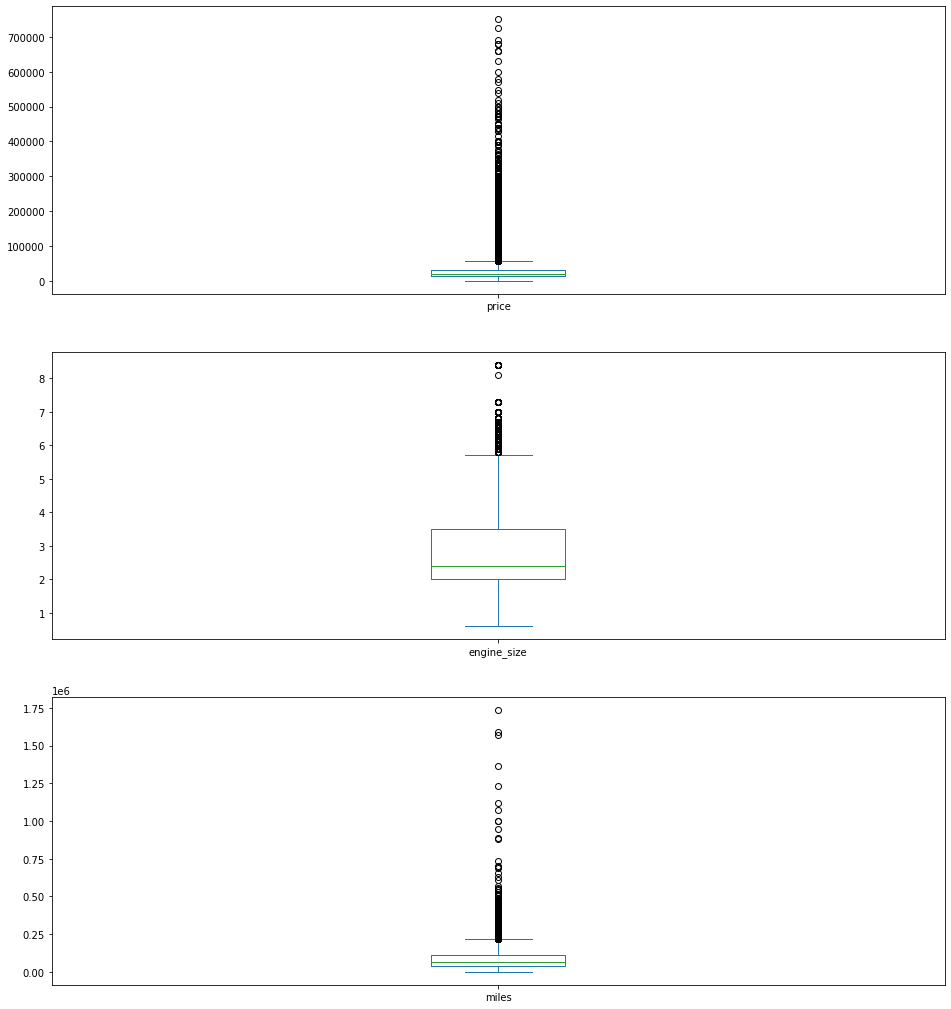

In [75]:
def plot_box(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    i = 0
    for c in columns:
        df[c].plot.box(ax=axs[i])
        i+=1

col_to_plot = ['price', 'engine_size', 'miles']
display(df_copy.info())
plot_box(df_copy, col_to_plot)

,miles,price,engine_size,age
count,159096.000000,159096.000000,159096.000000,159096.000000
mean,74338.201884,23047.720490,2.571459,5.549995
std,47810.243556,11766.178829,0.984033,2.816444
min,1.000000,1100.000000,0.600000,0.000000
25%,38012.750000,13999.000000,2.000000,4.000000
50%,65047.000000,20719.500000,2.400000,5.000000
75%,104073.750000,29900.000000,3.300000,7.000000
max,212318.000000,58403.000000,5.700000,15.000000


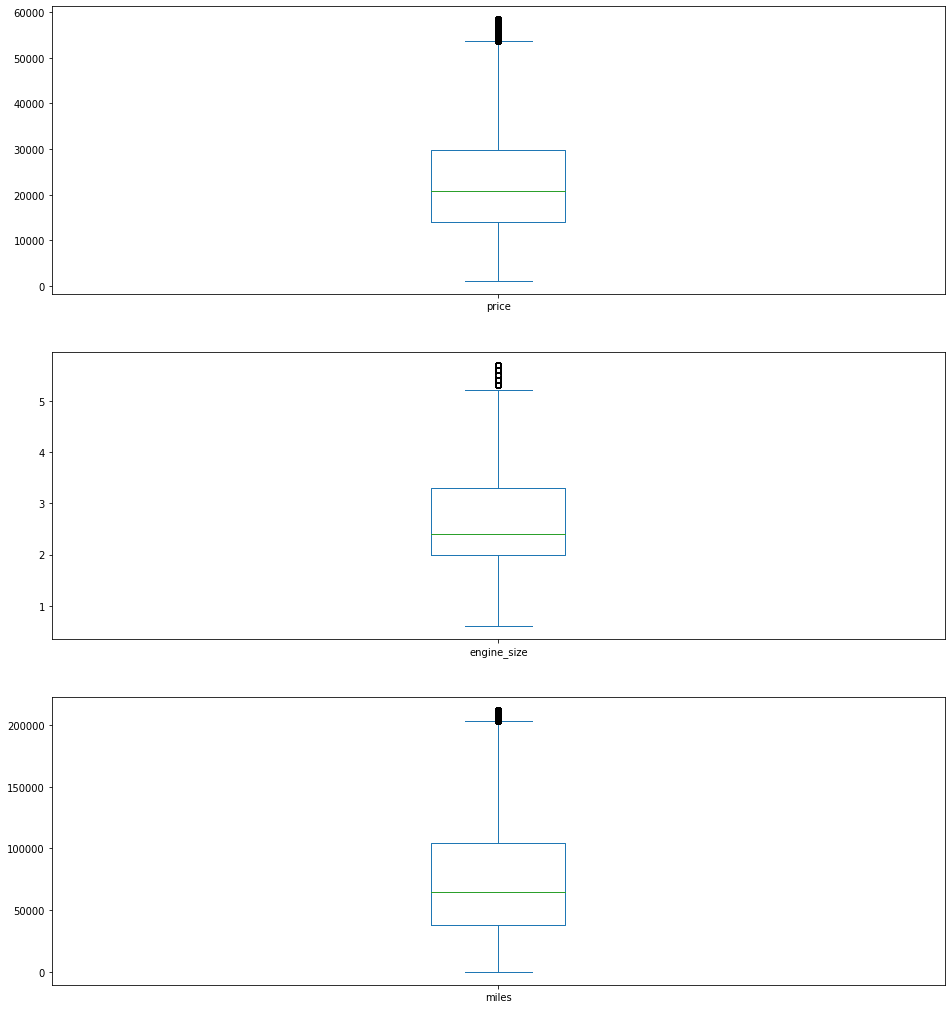

In [76]:
#Function to remove outliers
def remove_outliers(data, cols):
    for c in cols:
        q25 = data[c].quantile(0.25)
        q75 = data[c].quantile(0.75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower = 0 if q25 - cut_off < 0 else q25 - cut_off
        upper = q75 + cut_off
        data = data[(data[c] < upper) & (data[c] > lower)]
    
    return data

def save_outliers(data, c):
    q25 = data[c].quantile(0.25)
    q75 = data[c].quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower = 0 if q25 - cut_off < 0 else q25 - cut_off
    upper = q75 + cut_off
    outliers = data[(data[c] >= upper) | (data[c] <= lower)]
    return outliers

col_with_outliers = col_to_plot   
df_sub = remove_outliers(df_copy, col_with_outliers)

price_outliers = save_outliers(df_copy, 'price')
miles_outliers = save_outliers(df_copy, 'miles')
display(df_sub.describe())

plot_box(df_sub, col_with_outliers)

### Final Cleanup

Finally, we drop rows missing values from certain columns:
* **vin** : fundamental attribute, cannot be retrieved from others
* **miles** : cannot be retrieved from any other columns
* **model** : is obfuscated in VIN (not a 1-to-1 mapping) since it varies across manufacturers (makes)
* **body_type** : is also obfuscated in VIN (unique to each make); if missing for a particular model of a make, cannot be retrieved from other models
* **city** : even if seller_name is available, if city is missing, it is missing in all instances of seller_name (available or also missing)  
* **province** : same reason as city


In [77]:
# get a preview of the state of the dataset prior to dropping any rows
print(f'State of the Dataset before dropping any rows...')
display(df_copy.info())

# we drop rows missing values from certain columns
df_copy.dropna(inplace=True)

# preview after dropping some rows based on above conditions
print(f'State of the Dataset after dropping some rows...')
display(df_copy.info())

State of the Dataset before dropping any rows...
<class 'pandas.core.frame.DataFrame'>
Index: 201738 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           201738 non-null  object 
 1   make          201738 non-null  object 
 2   model         201573 non-null  object 
 3   year          201738 non-null  object 
 4   miles         190494 non-null  float64
 5   price         182611 non-null  float64
 6   fuel_type     178155 non-null  object 
 7   engine_size   201585 non-null  float64
 8   body_type     201738 non-null  object 
 9   vehicle_type  199389 non-null  object 
 10  transmission  180525 non-null  object 
 11  drivetrain    180480 non-null  object 
 12  seller_name   200700 non-null  object 
 13  city          198411 non-null  object 
 14  province      198357 non-null  object 
 15  age           201738 non-null  float64
dtypes: float64(4), object(12)
mem

None

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/3910400635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy.dropna(inplace=True)


State of the Dataset after dropping some rows...
<class 'pandas.core.frame.DataFrame'>
Index: 151392 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           151392 non-null  object 
 1   make          151392 non-null  object 
 2   model         151392 non-null  object 
 3   year          151392 non-null  object 
 4   miles         151392 non-null  float64
 5   price         151392 non-null  float64
 6   fuel_type     151392 non-null  object 
 7   engine_size   151392 non-null  float64
 8   body_type     151392 non-null  object 
 9   vehicle_type  151392 non-null  object 
 10  transmission  151392 non-null  object 
 11  drivetrain    151392 non-null  object 
 12  seller_name   151392 non-null  object 
 13  city          151392 non-null  object 
 14  province      151392 non-null  object 
 15  age           151392 non-null  float64
dtypes: float64(4), object(12)
mem

None

### Sub-sampling to create working dataset

Once we have dropped duplicate records, filled in missing data and taken care of outliers, it's finally time to select a sub-sample of our still dirty, but *slightly* cleaned, dataset.

For this, we created a random sampler. Given the size of our initial dataset, and the size of the desired sample, it creates bins of roughly same sizes and randomly selects indices from each of these bins. These indices correspond to the indices of rows we will select from our main dataset, which we then proceed to select.

In [17]:
# generates and returns a random sample of indices [0...n-1] of length, size_sub_df
def random_sampler(size_initial_df,  size_sub_df):
    bin_size = round(size_initial_df/size_sub_df)
    sample_indices = []
    low = 0
    high = 1

    for i in range(0, size_sub_df+1):
        sample_indices.append(np.random.randint((low*bin_size), (high*bin_size)))
        low+=1
        high+=1

    return sample_indices

# generate a list of 1500 random indices between 0 and n-1; n=len(df)
sample_indices = random_sampler(len(df_copy), 1500)
# display(sample_indices)

# use generated indices to sample initial dataframe and create and subset
df_sub = df_copy.iloc[sample_indices, :].copy()
df_sub.info()

IndexError: positional indexers are out-of-bounds

### Data Presentation

Since our data is not temporal, we plotted each numerical attribute against its frequency. Below are the non-normalized probability distribution functions.

In [ ]:
# because our data is not temporal, nor is it reasonable to plot against our index ('id'),
# the natural progression is to plot the 

# plots non-normalized distribution
def plot_all_series(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    axs = axs.flatten()
    i = 0
    for c in columns:
        temp_ser = df.groupby(by=[c]).size()
        axs[i].scatter(x=temp_ser.index, y=temp_ser, label=columns[i])
        axs[i].legend(loc='upper center')
        i+=1

plot_all_series(df_sub, col_to_plot)

So instead, we plot normalized probability density functions of our numerical attributes. We also utilize histograms as they better describe the congregation of certain values.

In [ ]:
def plot_histograms_density(df, columns):
    fig, axs = plt.subplots(len(columns),1,figsize=(16,18))
    i = 0
    for c in columns:
        df[c].hist(ax=axs[i], density=True)
        df[c].plot.density(ax=axs[i], title=c)
        i+=1

col_to_plot = ['price', 'miles', 'age', 'engine_size']
plot_histograms_density(df_sub, col_to_plot)

ITERATION 2 BEGINS
First we need to encode the categorical variables. We will use label encoding for this.
Next, we will experiment with different scaling techniques to see what works best for our data. We will use MinMaxScaler, MaxAbsSacaler, RobustScaler, QuantileTransformer, Z-Score and Log Transformation.
Then, we will combine our scaling techniques with our models to see which combination works best for our data.

In [78]:
#Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

#Using Label encoding for make, model, body_type, vehicle_type, fuel_type, transmission
le = LabelEncoder() 

df_le = df_sub.copy()
df_le['make'] = le.fit_transform(df_le['make'])
df_le['model'] = le.fit_transform(df_le['model'])
df_le['body_type'] = le.fit_transform(df_le['body_type'])
df_le['vehicle_type'] = le.fit_transform(df_le['vehicle_type'])
df_le['fuel_type'] = le.fit_transform(df_le['fuel_type'])
df_le['transmission'] = le.fit_transform(df_le['transmission'])

display(df_le)

#Dropping rows that are not relevent to our model predictions based on our domain knowledge

df_le.drop(columns=['vin', 'drivetrain', 'seller_name', 'city', 'province'], inplace=True)
display(df_le.info())

,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province,age
id,,,,,,,,,,,,,,,,
a7b53aaa-ae99,1B3LC56R18N652133,10,73,2008,174850.0,3499.0,4,2.7,17,0,0,FWD,carview motor,North York,ON,14.0
acdf10ba-fa76,1B3LC56R18N660054,10,73,2008,89124.0,5200.0,4,2.7,17,0,0,FWD,strickland's brantford chevrolet buick gmc cad...,Brantford,ON,14.0
3ec82d01-aec0,1B3LC56R38N195597,10,73,2008,151745.0,4789.0,4,2.7,17,0,0,FWD,dale wurfel chrysler dodge jeep ltd.,Strathroy,ON,14.0
d128f381-0f23,1B3LC56R88N566740,10,73,2008,176631.0,5995.0,4,2.7,17,0,0,FWD,first edmonton auto,Edmonton,AB,14.0
072f8e65-1a4e,1C3BC8FG0BN584106,9,3,2011,105060.0,6991.0,4,3.6,17,0,0,FWD,formule subaru inc,Rimouski,QC,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049272b-7afa,WDC0G5EB7JV031229,28,259,2018,71992.0,39498.0,12,2.0,16,1,0,4WD,hgrgoire nissan saint-eustache,Saint-eustache,QC,4.0
12c697a9-e4aa,WDC0G5EB7JV031599,28,259,2018,58514.0,46388.0,12,2.0,16,1,0,4WD,pioneer auto group,Mission,BC,4.0
a02fbcbc-9f63,WDC0G5EB7JV034017,28,259,2018,68665.0,43900.0,12,2.0,16,1,0,4WD,hyundai repentigny,Repentigny,QC,4.0


<class 'pandas.core.frame.DataFrame'>
Index: 159096 entries, a7b53aaa-ae99 to 873d76f0-18d2
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          159096 non-null  int32  
 1   model         159096 non-null  int32  
 2   year          159096 non-null  object 
 3   miles         159096 non-null  float64
 4   price         159096 non-null  float64
 5   fuel_type     159096 non-null  int32  
 6   engine_size   159096 non-null  float64
 7   body_type     159096 non-null  int32  
 8   vehicle_type  159096 non-null  int32  
 9   transmission  159096 non-null  int32  
 10  age           159096 non-null  float64
dtypes: float64(4), int32(6), object(1)
memory usage: 10.9+ MB


None

Preprocessing - Exploring Data Scaling Techniques

,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,0.478065,0.478284,0.630003,0.350124,0.383012,0.824736,0.386561,0.822636,0.290711,0.138074,0.370000
std,0.270939,0.269976,0.187764,0.225183,0.205333,0.172853,0.192948,0.173417,0.258186,0.318475,0.187763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.240798,0.533333,0.179033,0.225102,0.722222,0.274510,0.777778,0.000000,0.000000,0.266667
50%,0.409091,0.447853,0.666667,0.306363,0.342382,0.888889,0.352941,0.888889,0.500000,0.000000,0.333333
75%,0.704545,0.713190,0.733333,0.490176,0.502591,0.888889,0.529412,0.944444,0.500000,0.000000,0.466667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


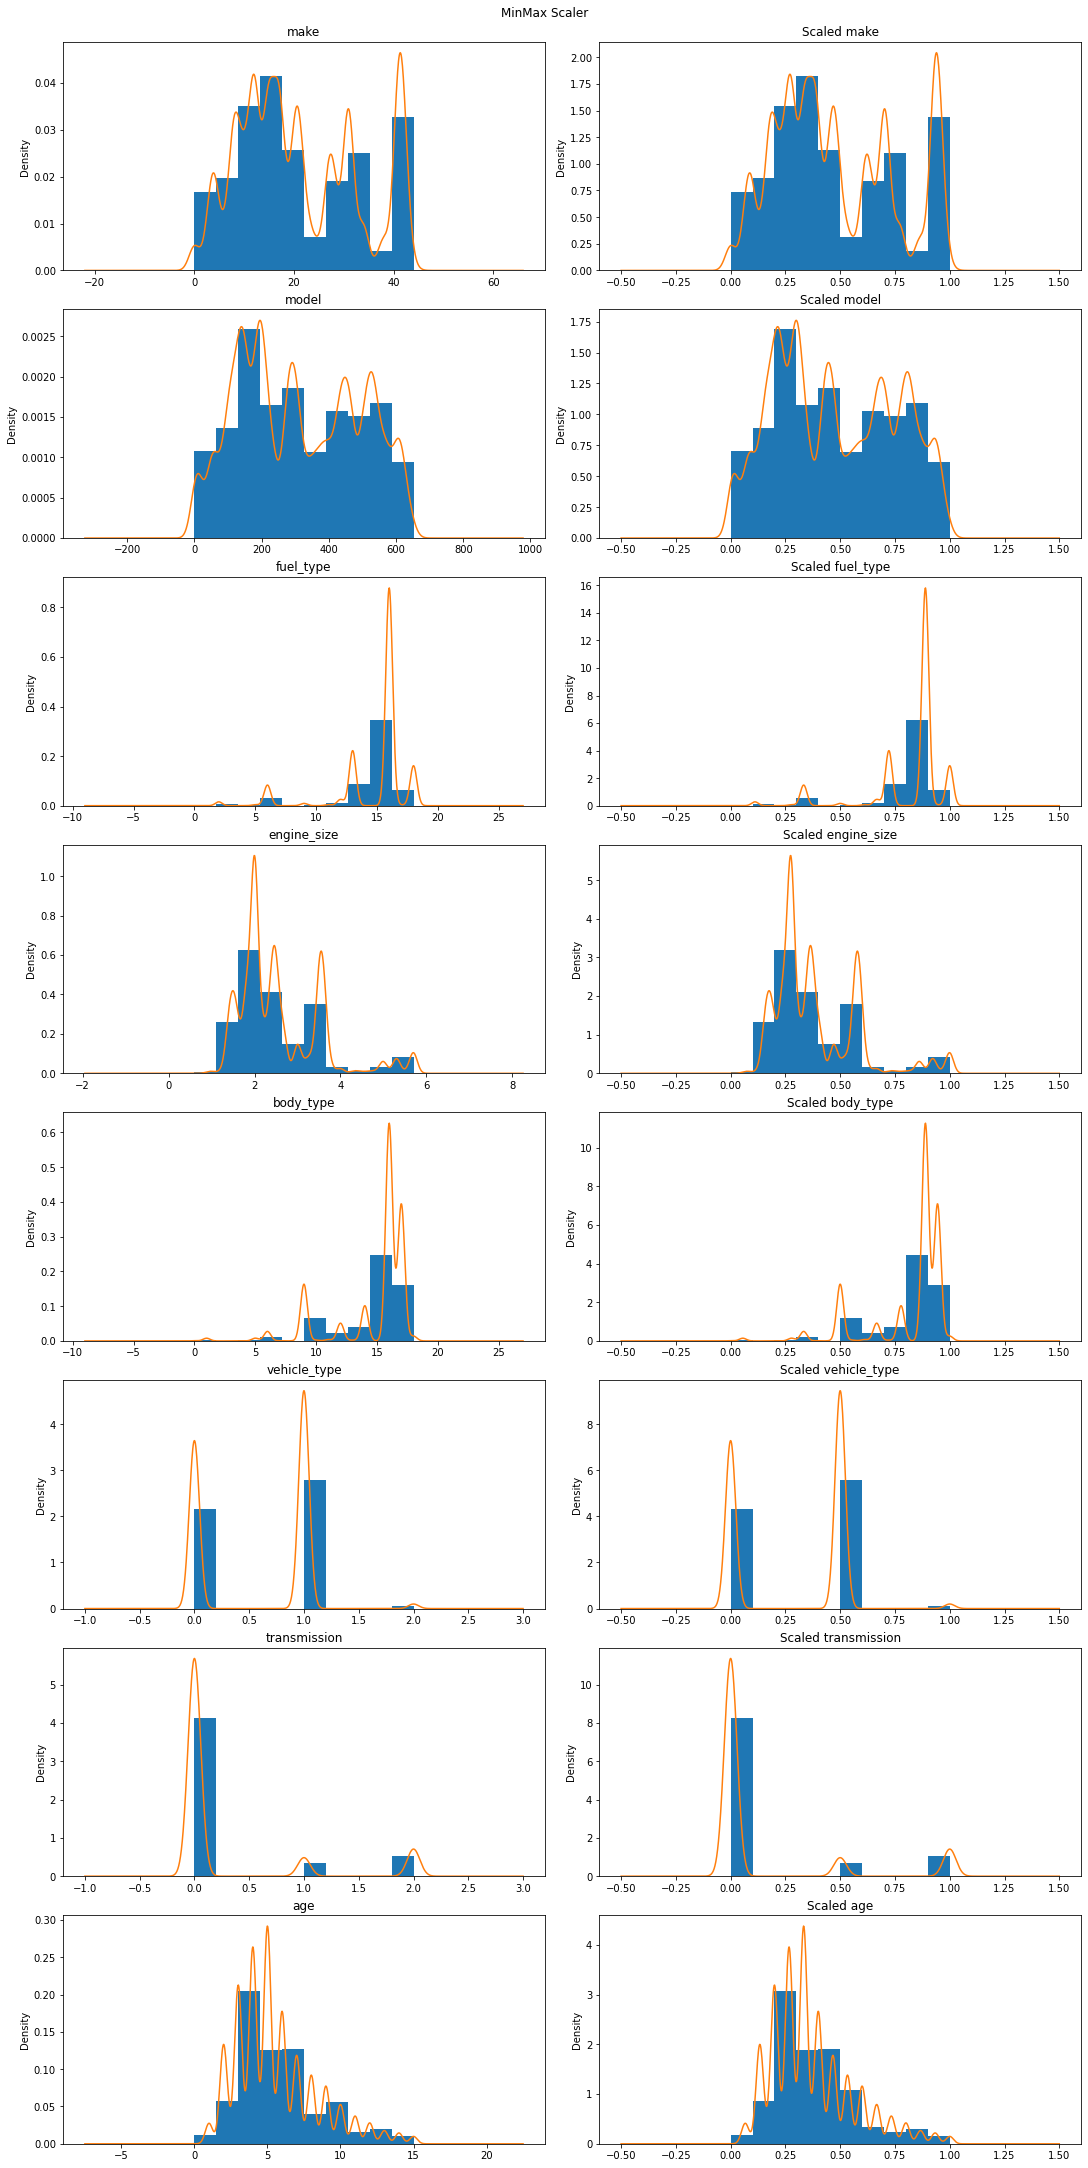

In [81]:
#Data Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
min_max_df = scaler.fit_transform(df_le)
min_max_df = pd.DataFrame(min_max_df, columns=df_le.columns)
min_max_df

def plot_histograms_density(df, columns, scaled_df, fig_title):
    fig, axs = plt.subplots(len(columns), 2, figsize=(15,30), constrained_layout=True)
    fig.suptitle(fig_title)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        df_le[c].hist(ax=axs[i], density=True)
        df_le[c].plot.density(ax=axs[i], title=c)
        
        scaled_df[c].hist(ax=axs[i+1], density=True, stacked=True)
        scaled_df[c].plot.density(ax=axs[i+1], title=str('Scaled ' + c))
        
        i+=2

cols_to_plot = ['make', 'model', 'fuel_type', 'engine_size', 'body_type', 'vehicle_type', 'transmission', 'age']

display(min_max_df.describe())
plot_histograms_density(df_le, cols_to_plot, min_max_df, 'MinMax Scaler')


,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,0.478065,0.478284,0.997255,0.350127,0.394632,0.824736,0.451133,0.822636,0.290711,0.138074,0.370000
std,0.270939,0.269976,0.001393,0.225182,0.201465,0.172853,0.172637,0.173417,0.258186,0.318475,0.187763
min,0.000000,0.000000,0.992582,0.000005,0.018835,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.240798,0.996538,0.179037,0.239697,0.722222,0.350877,0.777778,0.000000,0.000000,0.266667
50%,0.409091,0.447853,0.997527,0.306366,0.354768,0.888889,0.421053,0.888889,0.500000,0.000000,0.333333
75%,0.704545,0.713190,0.998022,0.490179,0.511960,0.888889,0.578947,0.944444,0.500000,0.000000,0.466667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


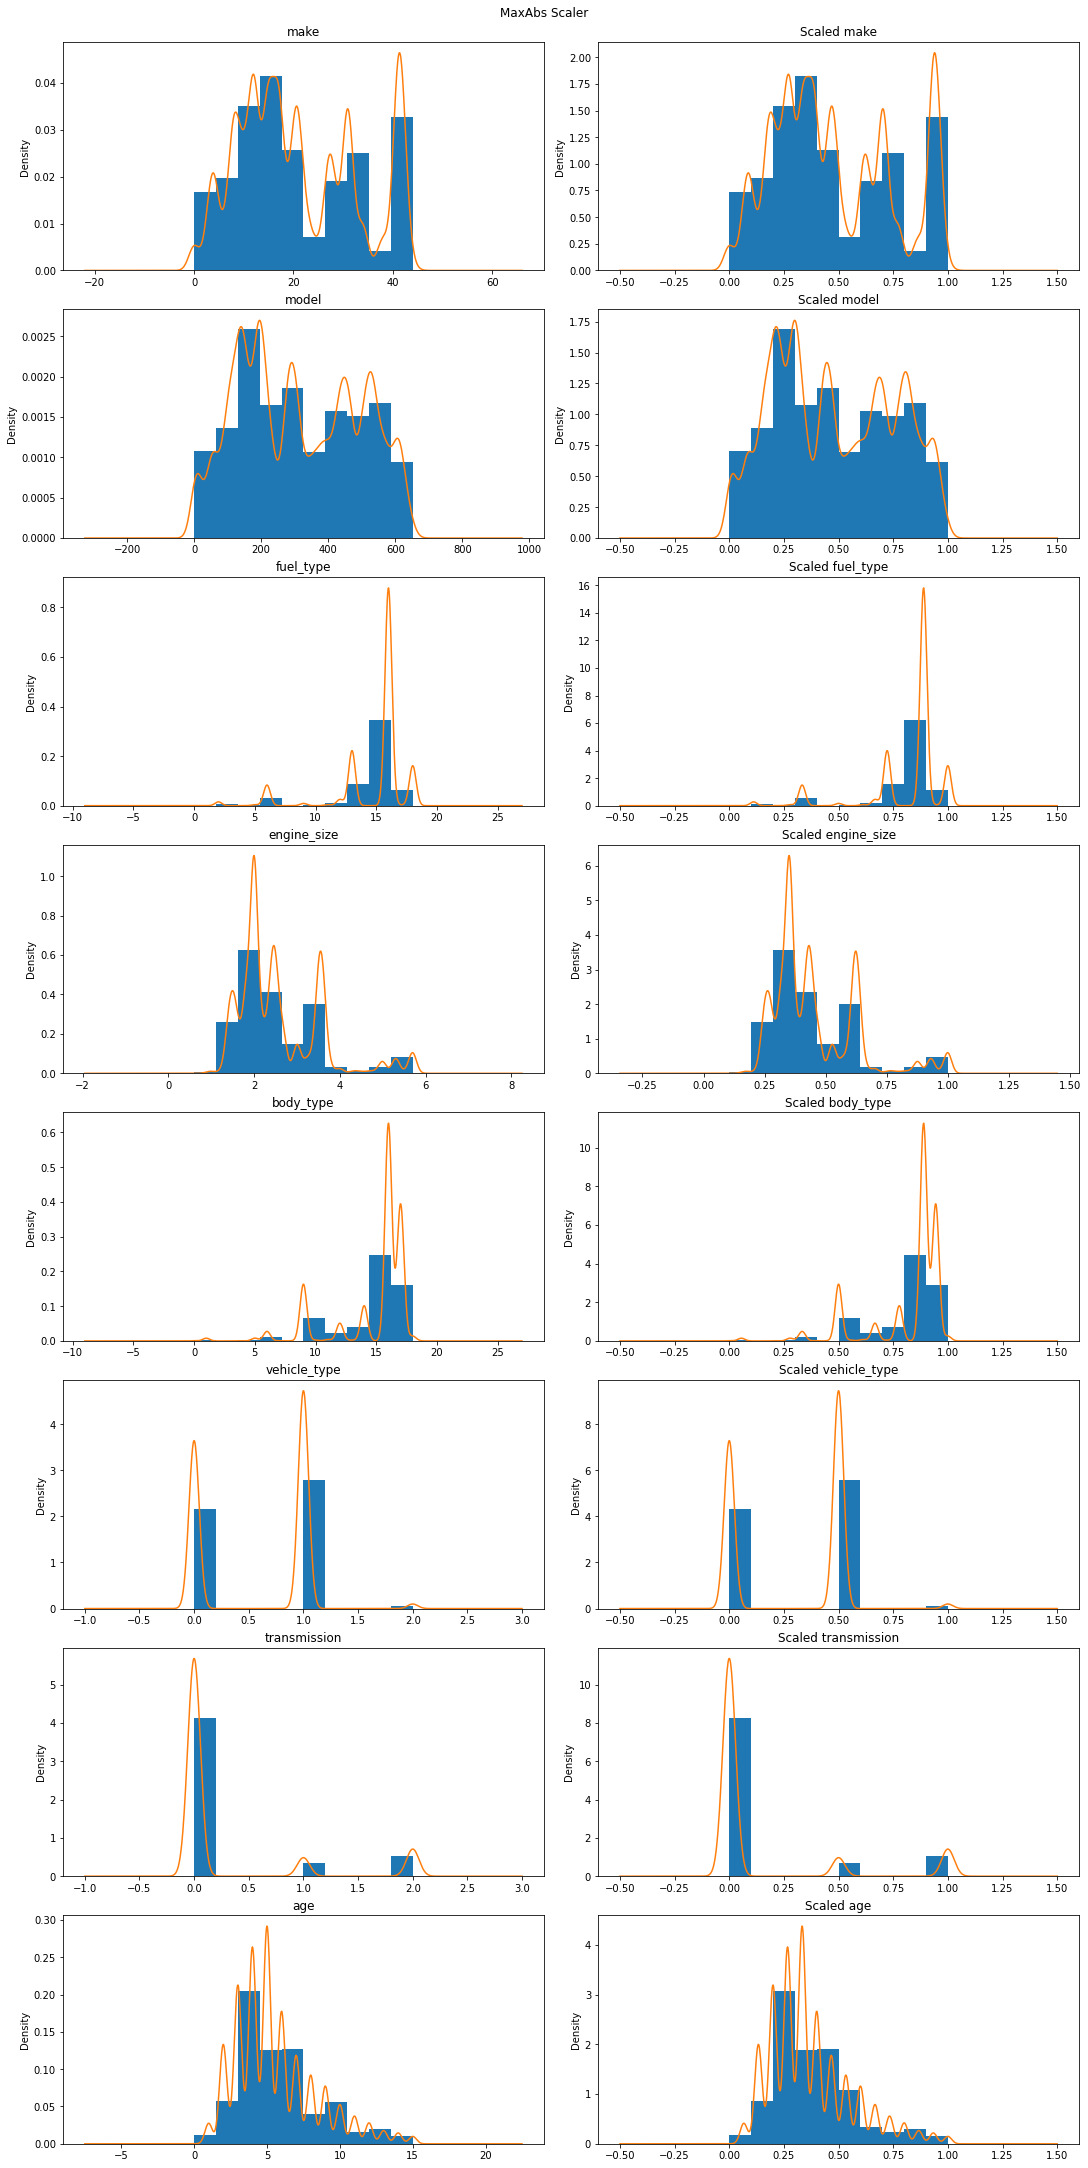

In [82]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
max_abs_df = scaler.fit_transform(df_le)
max_abs_df = pd.DataFrame(max_abs_df, columns=df_le.columns)
max_abs_df

display(max_abs_df.describe())
plot_histograms_density(df_le, cols_to_plot, max_abs_df, 'MaxAbs Scaler')

,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,0.159728,0.064419,-0.183319,0.140646,0.146420,-0.384916,0.131892,-0.397519,-0.418577,0.276148,0.183332
std,0.627437,0.571509,0.938820,0.723729,0.739965,1.037116,0.756949,1.040500,0.516373,0.636950,0.938815
min,-0.947368,-0.948052,-3.333333,-0.984635,-1.233853,-5.333333,-1.384615,-5.333333,-1.000000,0.000000,-1.666667
25%,-0.315789,-0.438312,-0.666667,-0.409232,-0.422646,-1.000000,-0.307692,-0.666667,-1.000000,0.000000,-0.333333
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.684211,0.561688,0.333333,0.590768,0.577354,0.000000,0.692308,0.333333,0.000000,0.000000,0.666667
max,1.368421,1.168831,1.666667,2.229318,2.369882,0.666667,2.538462,0.666667,1.000000,2.000000,3.333333


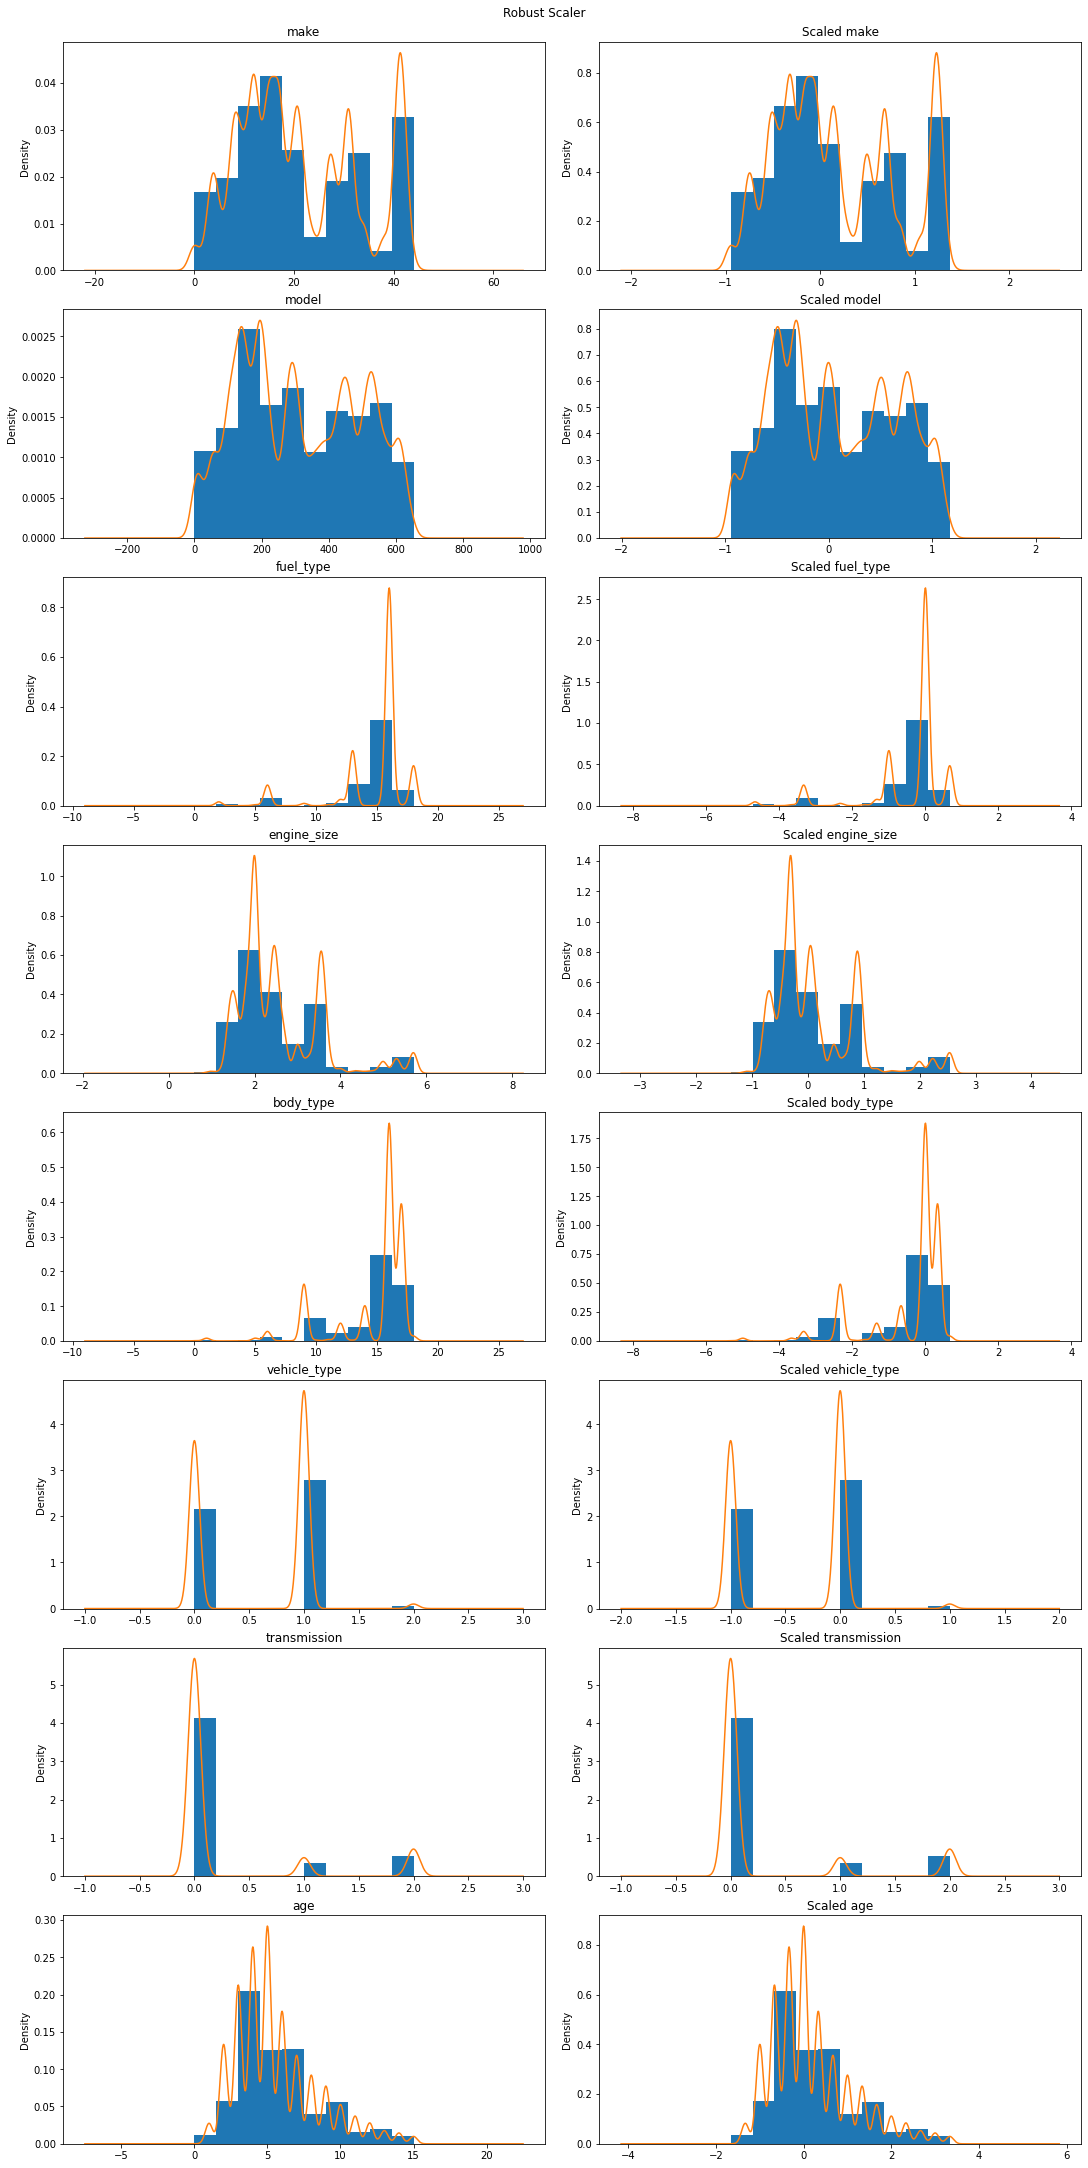

In [83]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
robust_df = scaler.fit_transform(df_le)
robust_df = pd.DataFrame(robust_df,columns=df_le.columns)
robust_df.describe()

display(robust_df.describe())
plot_histograms_density(df_le, cols_to_plot, robust_df, 'Robust Scaler')

,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,-0.094016,-0.031818,-0.045462,-0.039740,0.012412,0.371251,0.099480,0.031306,-1.935914,-3.677699,0.045477
std,1.089280,0.978887,0.997216,1.016559,0.901806,1.840882,1.146798,0.936247,2.881029,3.422155,0.997211
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.764710,-0.699172,-0.764710,-0.667671,-0.692105,-0.967422,-0.430727,-0.764710,-5.199338,-5.199338,-0.430727
50%,-0.069685,-0.036954,0.000000,-0.006278,-0.005841,0.139710,0.139710,0.000000,0.430727,-5.199338,0.000000
75%,0.764710,0.597120,0.430727,0.655198,0.655074,0.139710,0.677924,0.967422,0.430727,-5.199338,0.764710
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


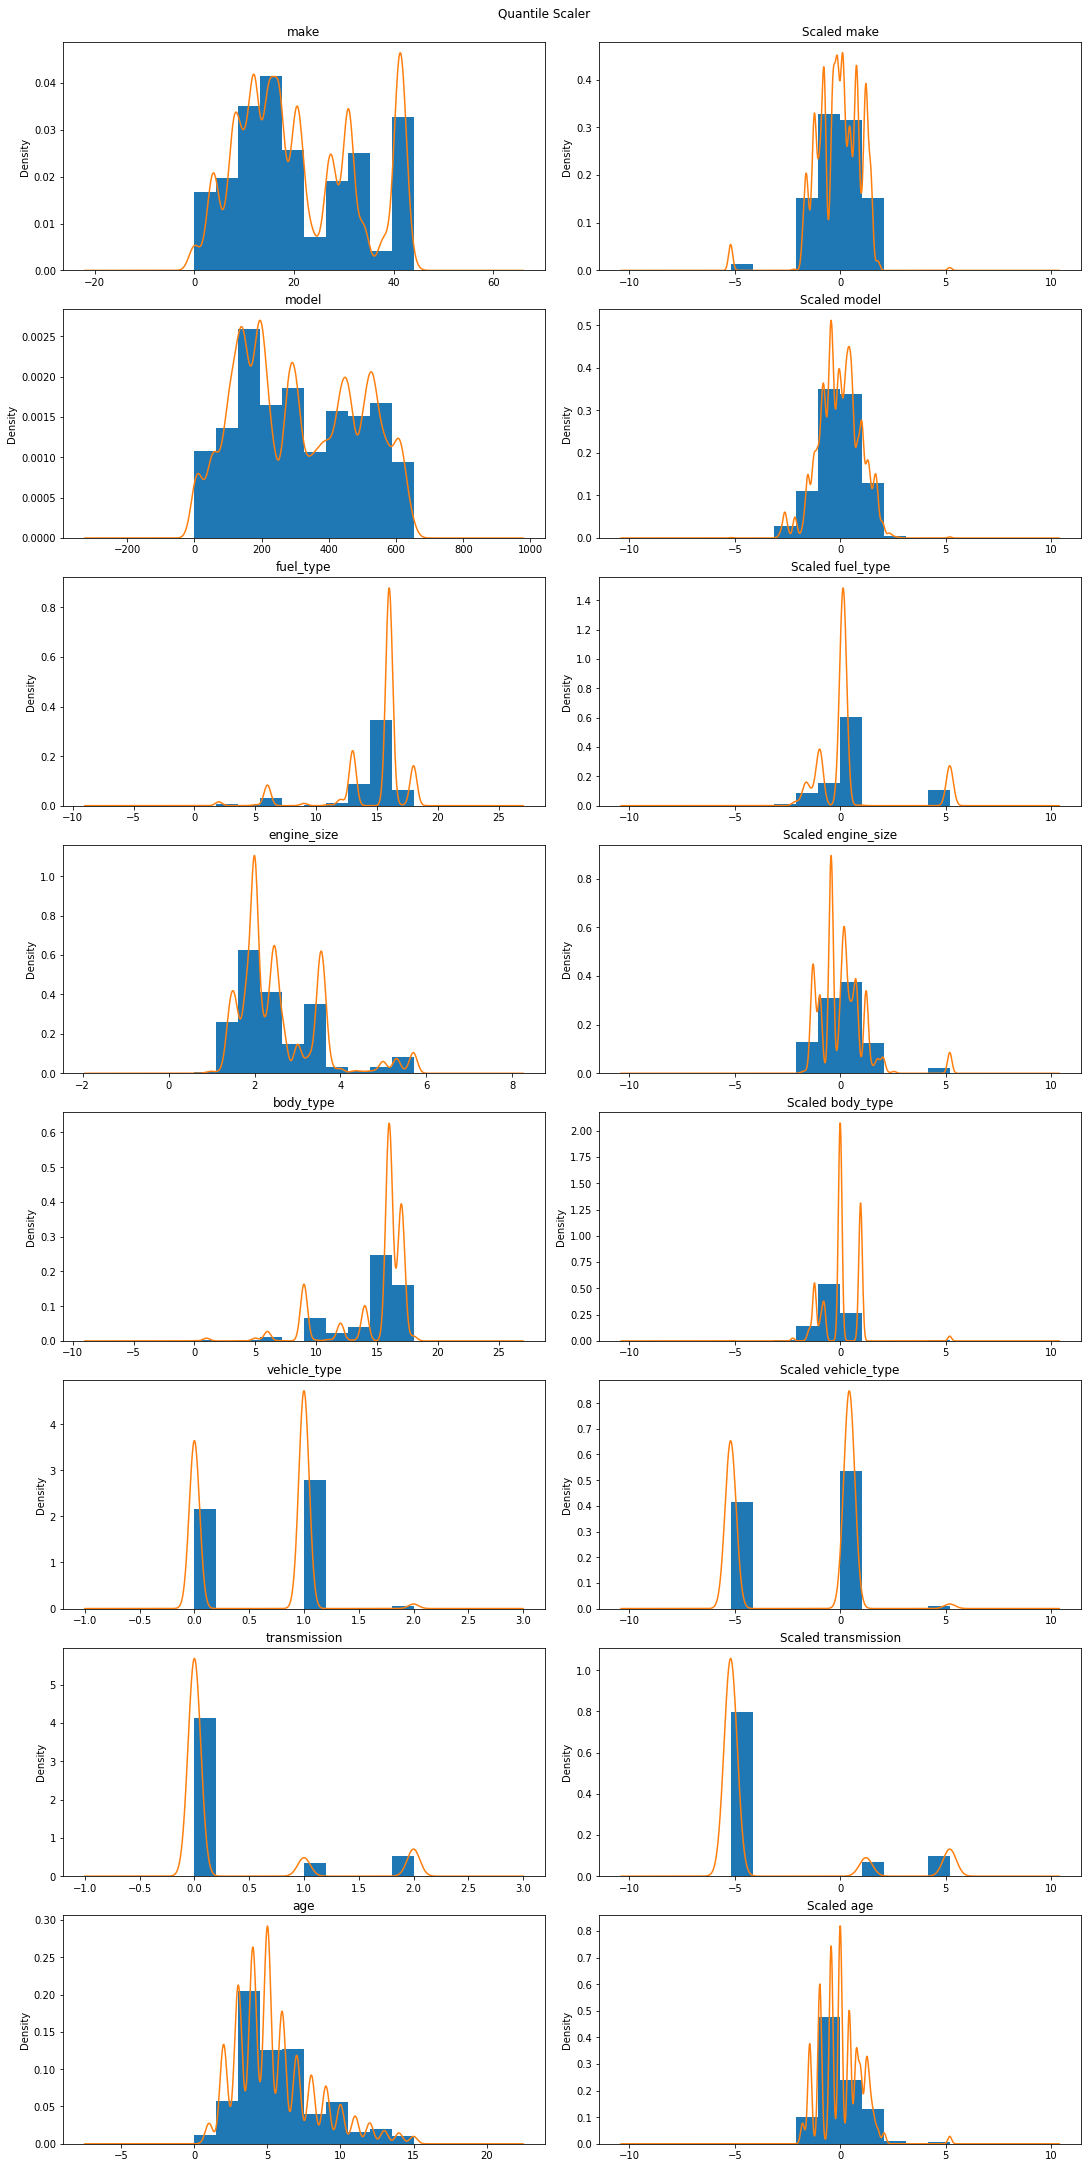

In [84]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')
quantile_df = scaler.fit_transform(df_le)
quantile_df = pd.DataFrame(quantile_df, index=df_le.index, columns=df_le.columns)

display(quantile_df.describe())
plot_histograms_density(df_le, cols_to_plot, quantile_df, 'Quantile Scaler')

,make,model,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,0.099622,0.961311,0.083125,0.014084,0.083827,0.002359,0.001539,0.032473
std,0.097131,0.127088,0.101545,0.019355,0.108391,0.003396,0.005572,0.051921
min,0.000000,0.000000,0.000000,0.000930,0.000000,0.000000,0.000000,0.000000
25%,0.039625,0.985053,0.030856,0.005358,0.031330,0.000000,0.000000,0.010027
50%,0.066439,0.994088,0.048009,0.008798,0.050433,0.001795,0.000000,0.017861
75%,0.109731,0.997585,0.098636,0.013837,0.090782,0.003381,0.000000,0.033671
max,0.880806,0.999739,0.906502,0.230505,0.923381,0.073331,0.100722,0.698620


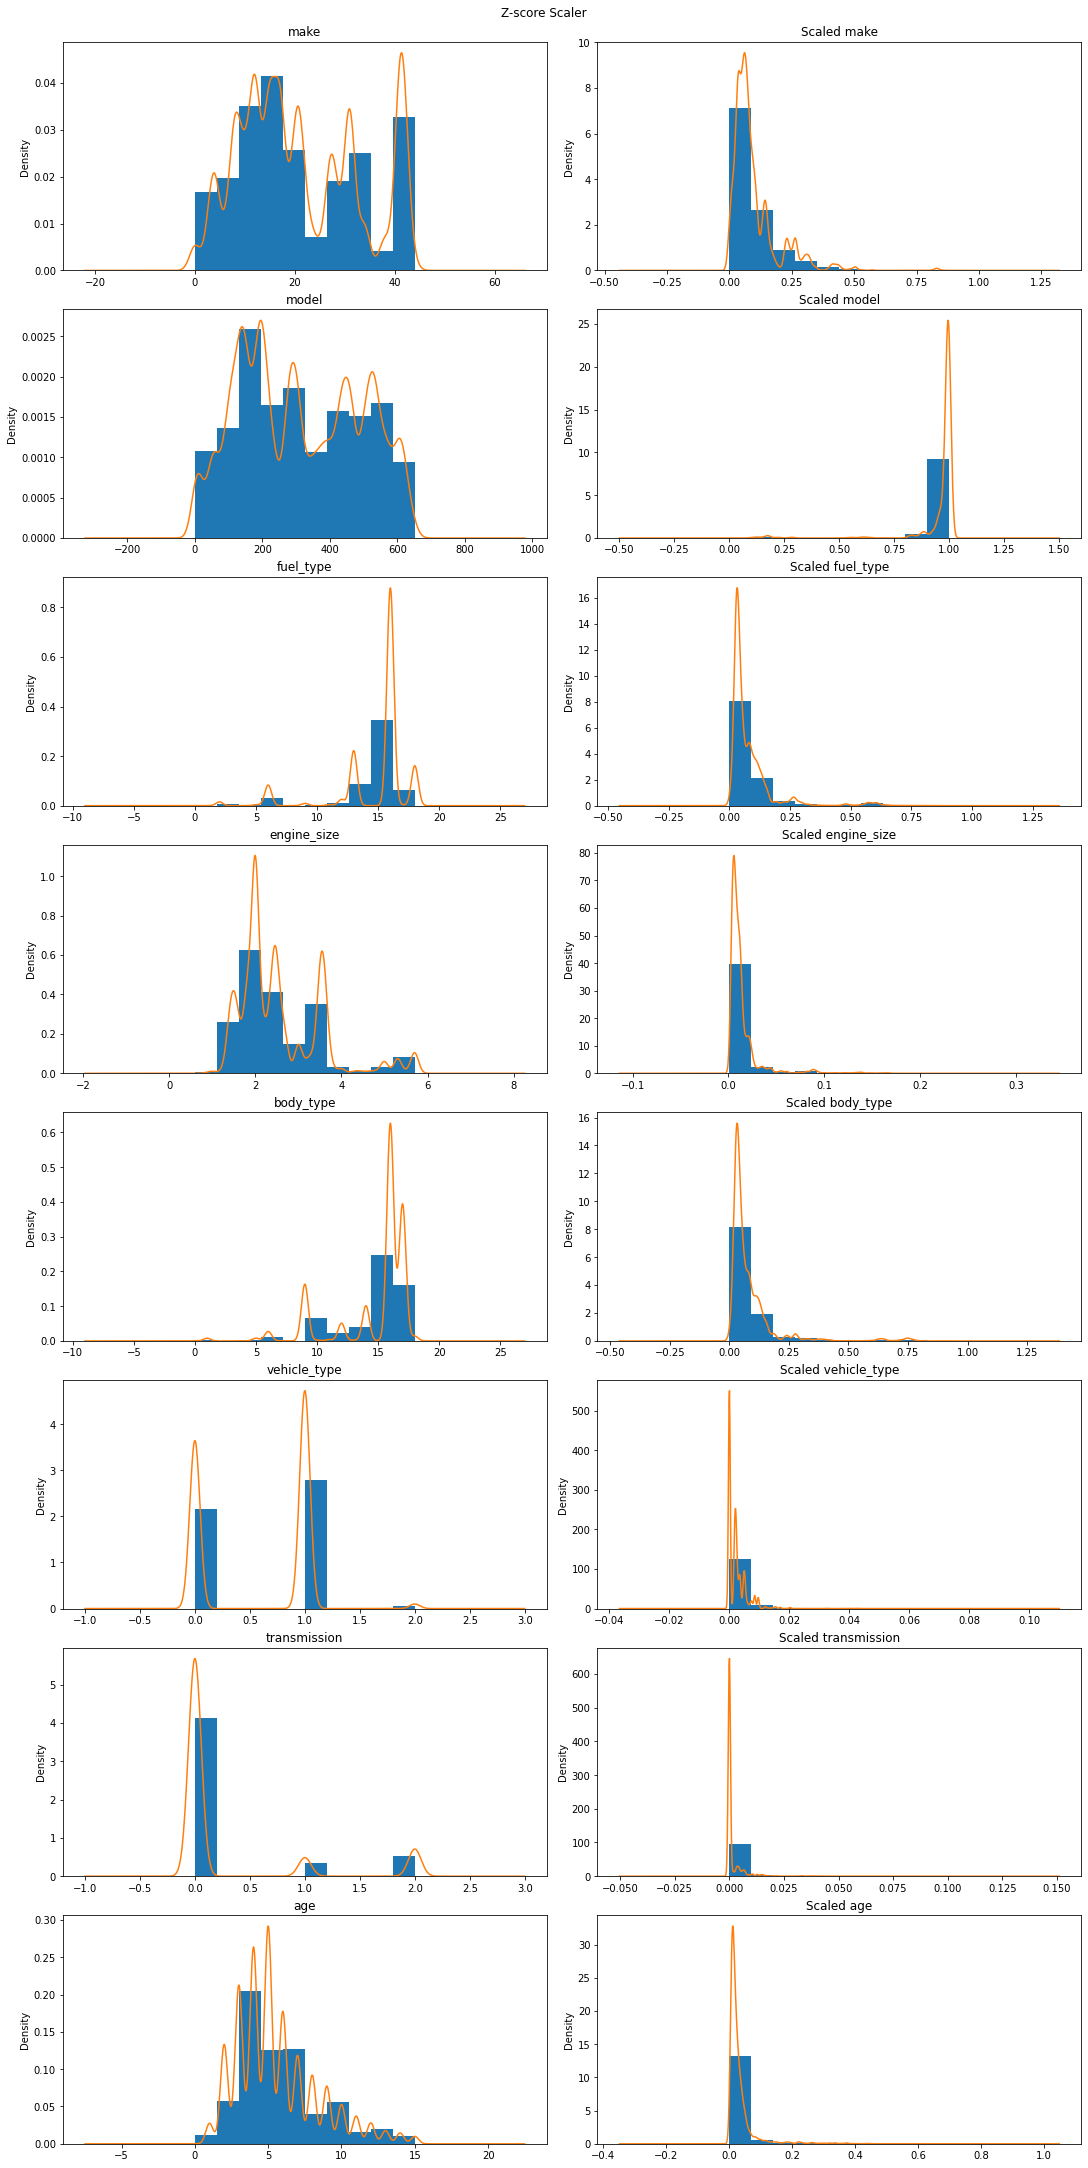

In [42]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
zscore_df = scaler.fit_transform(df_le)
zscore_df = pd.DataFrame(zscore_df, index=df_le.index, columns=df_le.columns)

display(zscore_df.describe())
plot_histograms_density(df_le, cols_to_plot, zscore_df, 'Z-score Scaler')

,make,model,fuel_type,engine_size,body_type,vehicle_type,transmission,age
count,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000,159096.000000
mean,2.902700,5.484973,2.731222,1.239985,2.730178,0.399664,0.161807,1.790916
std,0.693435,0.902636,0.289530,0.249324,0.283052,0.349969,0.363063,0.423560
min,0.000000,0.000000,0.000000,0.470004,0.000000,0.000000,0.000000,0.000000
25%,2.564949,5.062595,2.639057,1.098612,2.708050,0.000000,0.000000,1.609438
50%,2.944439,5.680173,2.833213,1.223775,2.833213,0.693147,0.000000,1.791759
75%,3.465736,6.144186,2.833213,1.458615,2.890372,0.693147,0.000000,2.079442
max,3.806662,6.481577,2.944439,1.902108,2.944439,1.098612,1.098612,2.772589


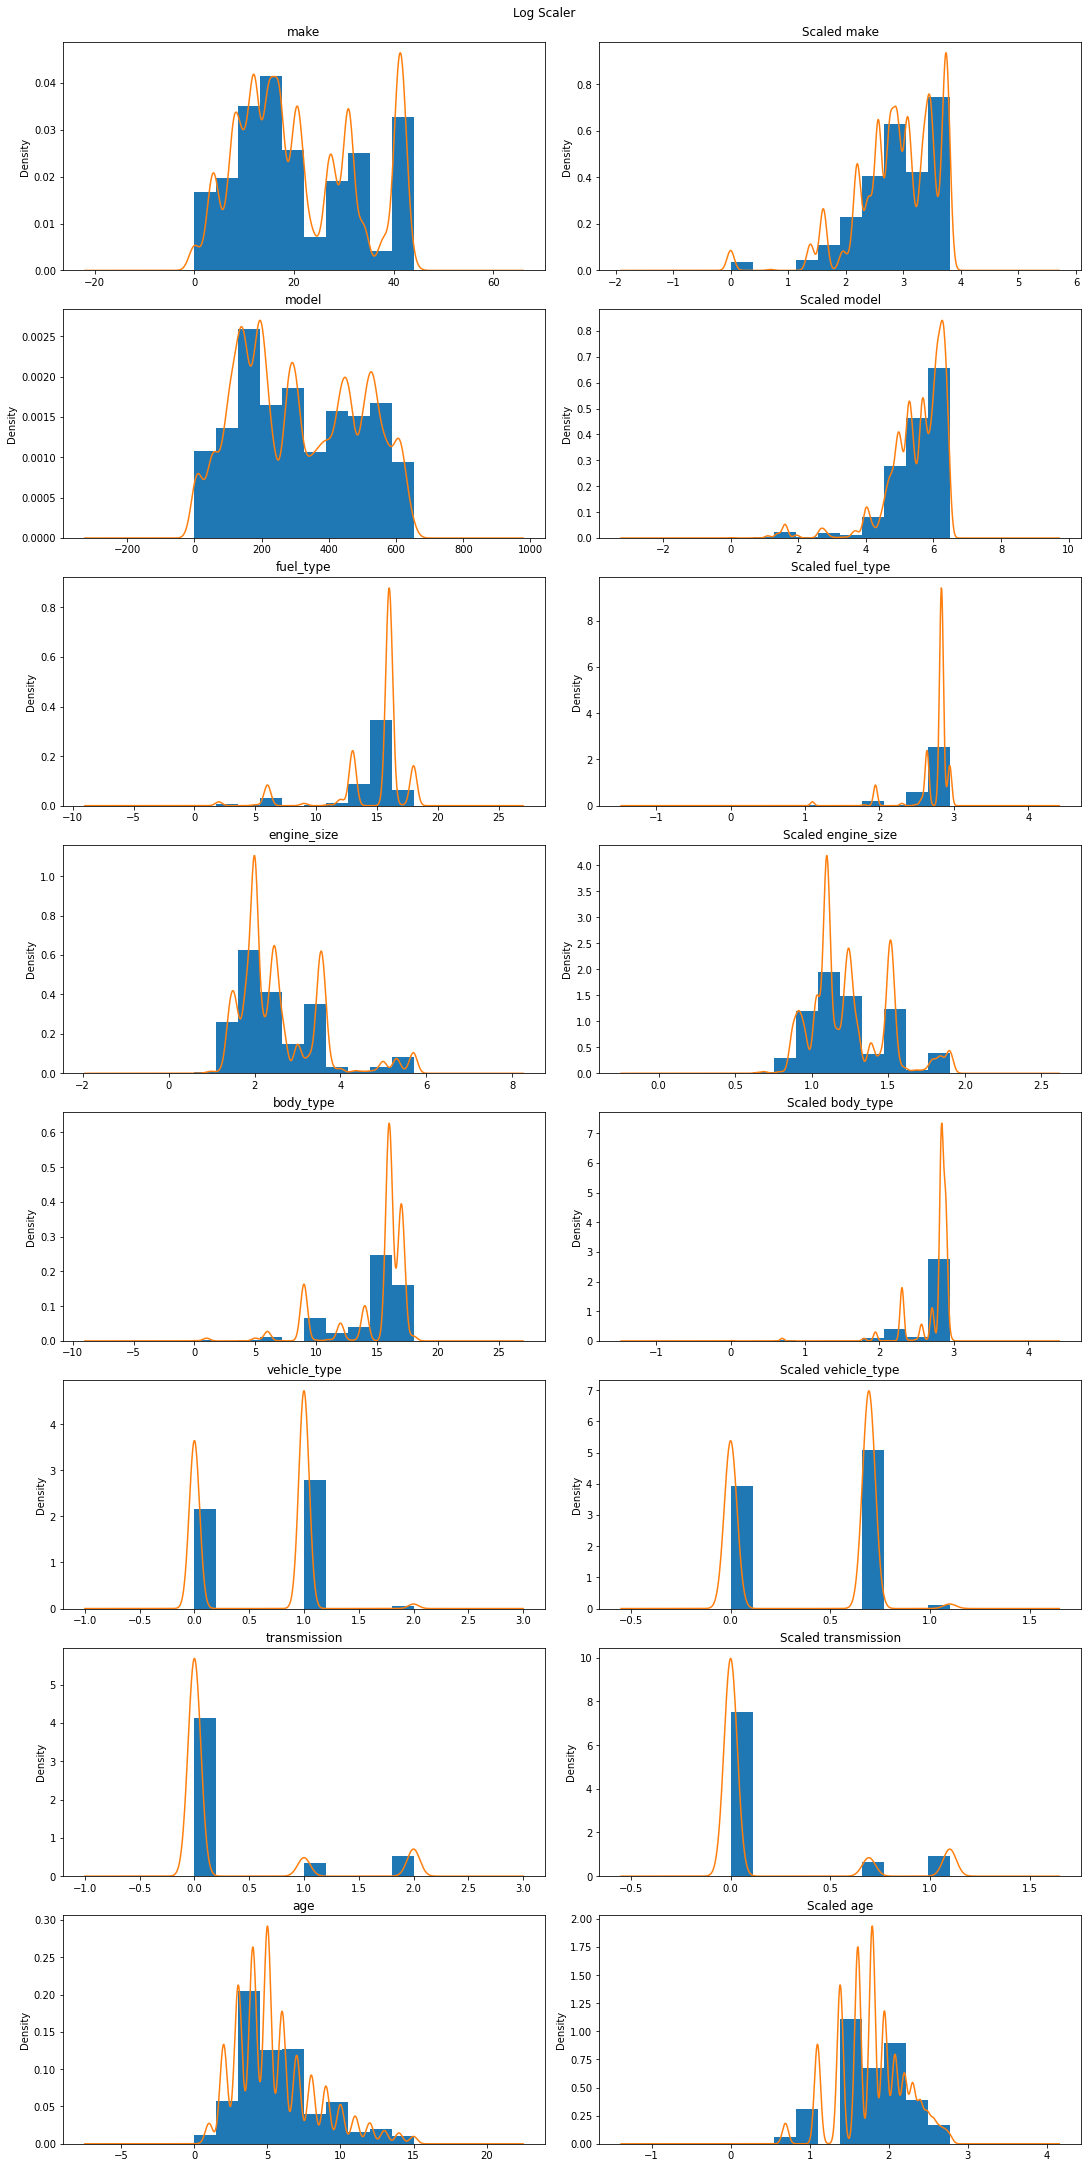

In [43]:
from sklearn.preprocessing import FunctionTransformer

scaler = FunctionTransformer(np.log1p)
log_df = scaler.fit_transform(df_le)
log_df = pd.DataFrame(log_df, index=df_le.index, columns=df_le.columns)

display(log_df.describe())
plot_histograms_density(df_le, cols_to_plot, log_df, 'Log Scaler')

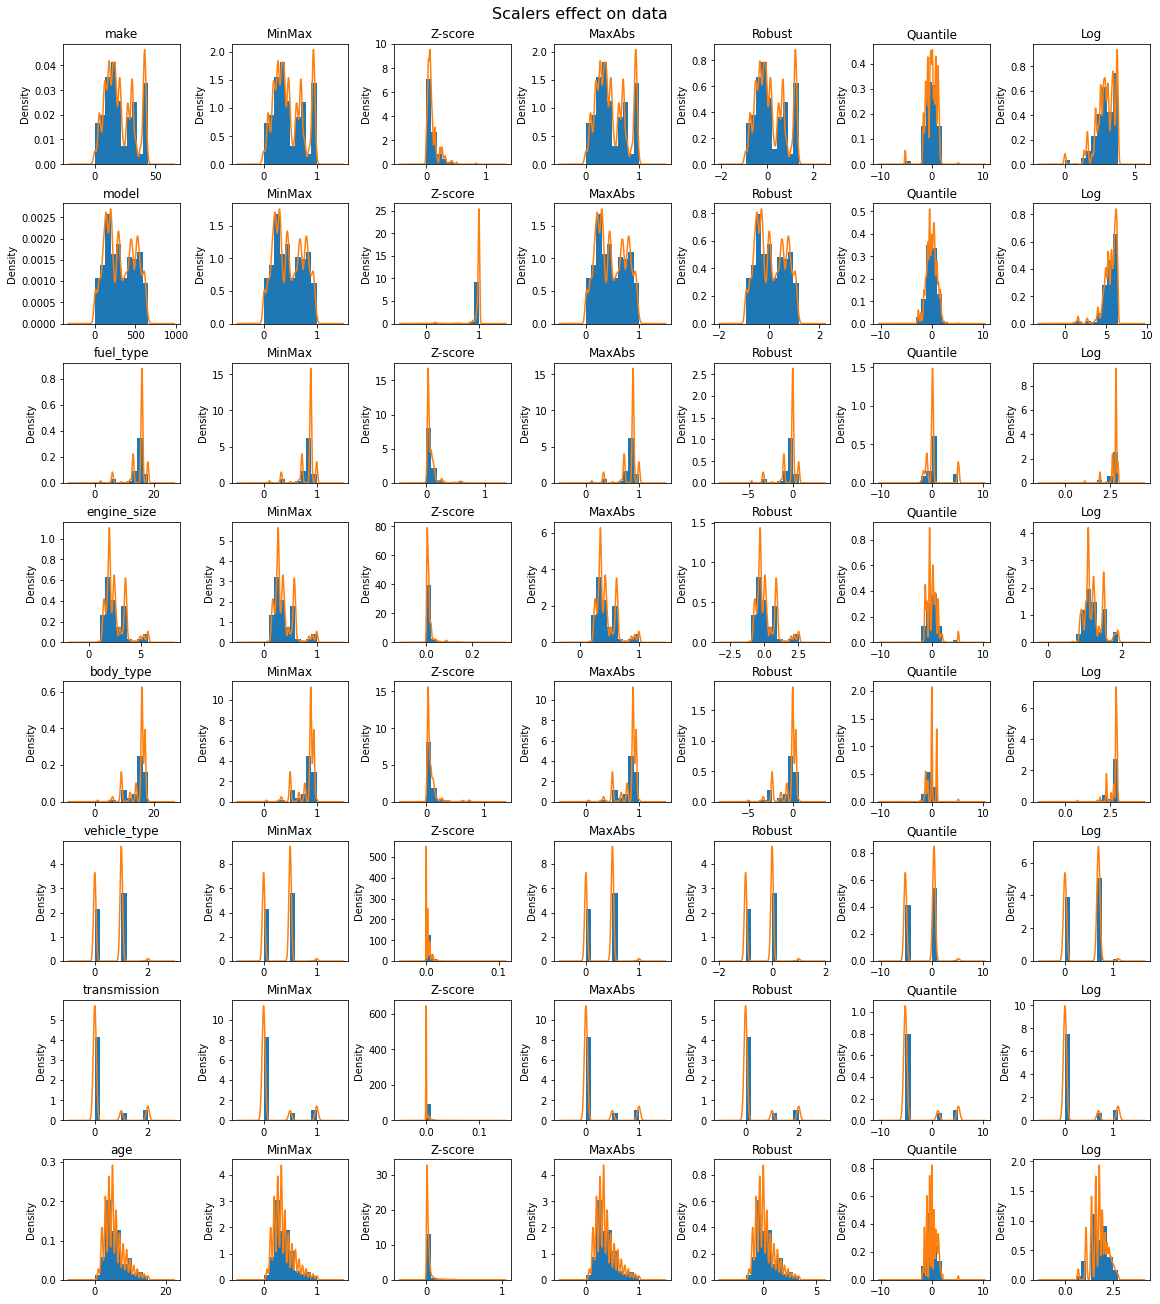

In [45]:
def plot_histograms_density_all_scalers(df, columns, fig_title, scalers, scaler_names):
    fig, axs = plt.subplots(len(columns),len(scalers)+1,figsize=(16,18),constrained_layout=True)
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        df[c].hist(ax=axs[i], density=True)
        df[c].plot.density(ax=axs[i], title=c)
        i+=1
        for j in range(len(scalers)):
            df_transformed = scalers[j].fit_transform(df)
            df_transformed = pd.DataFrame(df_transformed, index=df.index, columns=df.columns)
            df_transformed[c].hist(ax=axs[i], density=True, stacked=True)
            df_transformed[c].plot.density(ax=axs[i], title=scaler_names[j])
            i+=1
            

scaler_names = ['MinMax', 'Z-score', 'MaxAbs', 'Robust', 'Quantile', 'Log']
arr_scalers = [MinMaxScaler(), Normalizer(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal'),FunctionTransformer(np.log1p)]
plot_histograms_density_all_scalers(df_le, cols_to_plot, 'Scalers effect on data', arr_scalers, scaler_names)

We saved the data with missing engine_size values as a separate dataset, so that we can compare the results of filling in missing value with central tendency measures, with the results of using our best machine learning algorithm to predict the missing values.

In [79]:
display(engine_size_missing.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24505 entries, d295eb75-3688 to 4f37f5d6-5c4b
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           24505 non-null  object 
 1   make          24505 non-null  object 
 2   model         24340 non-null  object 
 3   year          24505 non-null  object 
 4   miles         23145 non-null  float64
 5   price         21286 non-null  float64
 6   fuel_type     1409 non-null   object 
 7   engine_size   0 non-null      float64
 8   body_type     24505 non-null  object 
 9   vehicle_type  22183 non-null  object 
 10  transmission  3605 non-null   object 
 11  drivetrain    3556 non-null   object 
 12  seller_name   24422 non-null  object 
 13  city          24233 non-null  object 
 14  province      24195 non-null  object 
 15  age           24505 non-null  float64
dtypes: float64(4), object(12)
memory usage: 3.2+ MB


None

In [ ]:
#Dropping columns that are not relevent to our model predictions based on our domain knowledge
engine_size_missing.drop(columns=['vin', 'year', 'drivetrain', 'seller_name', 'city', 'province'], inplace=True)

In [80]:
#Filling missing values with mean
engine_size_missing_copy = engine_size_missing.copy()
engine_size_missing['engine_size'].fillna(engine_size_missing[engine_size_missing['engine_size'].isna()]['body_type'].apply(fix_engine_size), inplace=True)

display(engine_size_missing_copy.info())
display(engine_size_missing.info())

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/687659097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_size_missing['engine_size'].fillna(engine_size_missing[engine_size_missing['engine_size'].isna()]['body_type'].apply(fix_engine_size), inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 24505 entries, d295eb75-3688 to 4f37f5d6-5c4b
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           24505 non-null  object 
 1   make          24505 non-null  object 
 2   model         24340 non-null  object 
 3   year          24505 non-null  object 
 4   miles         23145 non-null  float64
 5   price         21286 non-null  float64
 6   fuel_type     1409 non-null   object 
 7   engine_size   0 non-null      float64
 8   body_type     24505 non-null  object 
 9   vehicle_type  22183 non-null  object 
 10  transmission  3605 non-null   object 
 11  drivetrain    3556 non-null   object 
 12  seller_name   24422 non-null  object 
 13  city          24233 non-null  object 
 14  province      24195 non-null  object 
 15  age           24505 non-null  float64
dtypes: float64(4), object(12)
memory usage: 3.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 24505 entries, d295eb75-3688 to 4f37f5d6-5c4b
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           24505 non-null  object 
 1   make          24505 non-null  object 
 2   model         24340 non-null  object 
 3   year          24505 non-null  object 
 4   miles         23145 non-null  float64
 5   price         21286 non-null  float64
 6   fuel_type     1409 non-null   object 
 7   engine_size   24352 non-null  float64
 8   body_type     24505 non-null  object 
 9   vehicle_type  22183 non-null  object 
 10  transmission  3605 non-null   object 
 11  drivetrain    3556 non-null   object 
 12  seller_name   24422 non-null  object 
 13  city          24233 non-null  object 
 14  province      24195 non-null  object 
 15  age           24505 non-null  float64
dtypes: float64(4), object(12)
memory usage: 3.2+ MB


None

In [145]:
#Experimenting by combining algorithms with different scalers to see which combination is the best for our data

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
 
scaler_names = ['MinMax', 'MaxAbs', 'Robust', 'Quantile']
df_scaled = [min_max_df, max_abs_df, robust_df, quantile_df]

#Combining Linear regression model with the scaling techniques
linear_reg_scores = {}

print('Linear Regression Model:')
for i in range(len(df_scaled)):
    X = df_scaled[i].drop('engine_size', axis=1)
    y = df_scaled[i]['engine_size']
    model = LinearRegression()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    print(scaler_names[i] + ' Mean MSE: %.3f (%.3f)' % (np.mean(abs(n_scores)), np.std(abs(n_scores))))
    
    linear_reg_scores[scaler_names[i]] = abs(n_scores)



Linear Regression Model:
MinMax Mean Accuracy: 0.128 (0.001)
MaxAbs Mean Accuracy: 0.114 (0.001)
Robust Mean Accuracy: 0.502 (0.003)
Quantile Mean Accuracy: 0.708 (0.006)


In [147]:
from sklearn.neighbors import KNeighborsRegressor

#Combining KNeighbour Regressor model with the scaling techniques
KN_reg_scores = {}

for i in range(len(df_scaled)):
    X = df_scaled[i].drop('engine_size', axis=1)
    y = df_scaled[i]['engine_size']
    model = KNeighborsRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    
    print(scaler_names[i] + ' Mean MSE: %.3f (%.3f)' % (np.mean(abs(n_scores)), np.std(abs(n_scores))))
    
    KN_reg_scores[scaler_names[i]] = abs(n_scores)

MinMax Mean MSE: 0.022 (0.000)
MaxAbs Mean MSE: 0.020 (0.000)
Robust Mean MSE: 0.088 (0.002)
Quantile Mean MSE: 0.126 (0.003)


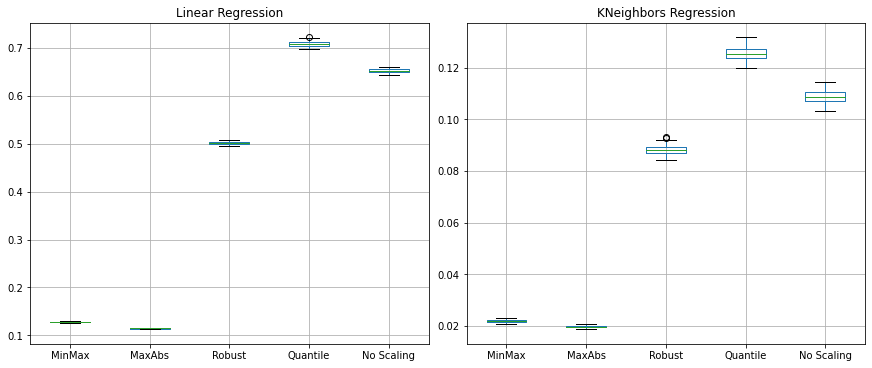

In [152]:
#Plotting the results of the cross validation scores for the two models combined with the different scalers

fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

#Accuracy of the models without scaling
X = df_le.drop('engine_size', axis=1)
y = df_le['engine_size']

l_scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
linear_reg_scores['No Scaling'] = abs(l_scores)


k_scores = cross_val_score(KNeighborsRegressor(), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
KN_reg_scores['No Scaling'] = abs(k_scores)

#Plotting boxplots for the models with and without scaling
df_log = pd.DataFrame(linear_reg_scores).boxplot(ax=axs[0]).set_title('Linear Regression')
df_kn = pd.DataFrame(KN_reg_scores).boxplot(ax=axs[1]).set_title('KNeighbors Regression')

From our experiments and the plots above, we can see that the best model and scaling technique for our data is MaxAbs scaling combined with KN Regression algorithm, since the Mean Absolute Error is the lowest for this combination. We will use this combination to fill in the missing values for engine_size. We chose Mean Absolute Error as our metric for evaluating the performance of our models, because it helps us understand the average magnitude of the errors in a set of predictions, without considering their direction.

In [159]:
engine_size_missing_copy['make'] = le.fit_transform(engine_size_missing_copy['make'])
engine_size_missing_copy['model'] = le.fit_transform(engine_size_missing_copy['model'])
engine_size_missing_copy['body_type'] = le.fit_transform(engine_size_missing_copy['body_type'])
engine_size_missing_copy['vehicle_type'] = le.fit_transform(engine_size_missing_copy['vehicle_type'])
engine_size_missing_copy['fuel_type'] = le.fit_transform(engine_size_missing_copy['fuel_type'])
engine_size_missing_copy['transmission'] = le.fit_transform(engine_size_missing_copy['transmission'])

display(engine_size_missing_copy)

scl = MaxAbsScaler()
model = KNeighborsRegressor()

X_a = df_le.drop('engine_size', axis=1)
y_a = df_le['engine_size']
X_train = scl.fit_transform(X_a)
y_train = y_a

model.fit(X_train, y_train)

X_b = engine_size_missing_copy.drop('engine_size', axis=1)

X_test = scl.transform(X_b)

engine_size = model.predict(X_test)

engine_size_missing_copy['engine_size'] = engine_size
display(engine_size_missing_copy)

,make,model,fuel_type,engine_size,body_type,vehicle_type,transmission,age
id,,,,,,,,
d295eb75-3688,8,533,5,NaN,16,0,0,8.0
a0dd2860-aac1,45,326,4,NaN,16,0,0,5.0
78af3839-df97,45,326,4,NaN,16,0,0,6.0
835fe8e0-1394,45,326,4,NaN,16,0,0,6.0
4b77942b-0ce6,45,326,4,NaN,16,0,0,6.0
...,...,...,...,...,...,...,...,...
98d52f09-3378,25,391,6,NaN,15,1,0,9.0
caec39a0-c733,32,75,6,NaN,5,0,0,9.0
f8c8f411-8baf,32,429,6,NaN,14,0,0,5.0


,make,model,fuel_type,engine_size,body_type,vehicle_type,transmission,age
id,,,,,,,,
d295eb75-3688,8,533,5,3.600000,16,0,0,8.0
a0dd2860-aac1,45,326,4,2.000000,16,0,0,5.0
78af3839-df97,45,326,4,2.000000,16,0,0,6.0
835fe8e0-1394,45,326,4,2.000000,16,0,0,6.0
4b77942b-0ce6,45,326,4,2.000000,16,0,0,6.0
...,...,...,...,...,...,...,...,...
98d52f09-3378,25,391,6,4.440000,15,1,0,9.0
caec39a0-c733,32,75,6,3.500000,5,0,0,9.0
f8c8f411-8baf,32,429,6,2.203106,14,0,0,5.0


In [23]:
#Fiiling missing values in year with our generate_year function

missing_year_copy = missing_year.copy()
missing_year['year'] = missing_year['vin'].apply(generate_year)
display(missing_year_copy.info())
display(missing_year.info())

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_17736/2191906527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_year['year'] = missing_year['vin'].apply(generate_year)


<class 'pandas.core.frame.DataFrame'>
Index: 40348 entries, e190cc9a-1062 to a02fbcbc-9f63
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vin           40348 non-null  object 
 1   make          40348 non-null  object 
 2   model         40313 non-null  object 
 3   year          0 non-null      object 
 4   miles         38064 non-null  float64
 5   price         36565 non-null  float64
 6   fuel_type     35647 non-null  object 
 7   engine_size   40321 non-null  float64
 8   body_type     40348 non-null  object 
 9   vehicle_type  39862 non-null  object 
 10  transmission  36150 non-null  object 
 11  drivetrain    36141 non-null  object 
 12  seller_name   40123 non-null  object 
 13  city          39659 non-null  object 
 14  province      39646 non-null  object 
 15  age           40348 non-null  float64
dtypes: float64(4), object(12)
memory usage: 5.2+ MB


None

,vin,make,model,year,miles,price,fuel_type,engine_size,body_type,vehicle_type,transmission,drivetrain,seller_name,city,province,age
id,,,,,,,,,,,,,,,,
e190cc9a-1062,19UNC1B07HY800115,Acura,NSX,2017,24510.0,174900.0,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,chambly honda,Chambly,QC,5.0
79d4a6a9-c265,19UNC1B0XHY800061,Acura,NSX,2017,12864.0,NaN,Electric / Premium Unleaded,3.5,Coupe,Car,Automatic,4WD,pfaff leasing calgary,Calgary,AB,5.0
28f7b8ce-430a,1FTEW1E50JFD64299,Ford,F-150,2018,98000.0,NaN,Unleaded / Unleaded,5.0,Pickup,Truck,Automatic,4WD,universal ford lincoln,Calgary,AB,4.0
8abd92bf-e859,1FTEW1E50JKC29959,Ford,F-150,2018,NaN,39995.0,Unleaded / Unleaded,5.0,Pickup,Truck,Automatic,4WD,ledingham chevrolet buick gmc,Steinbach,MB,4.0
3af8cbd4-3399,1FTEW1E50JKE54267,Ford,F-150,2018,102.0,51174.0,Unleaded / Unleaded,5.0,Pickup,Truck,Automatic,4WD,island truck store,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eb0892f0-32b8,WBA8E1C5XJK478592,BMW,3 Series,2018,34483.0,36900.0,Electric / Unleaded,2.0,Sedan,Car,Automatic,RWD,kelowna bmw,Kelowna,BC,4.0
1383a75d-b816,WDC0G5EB2JF471451,Mercedes-Benz,GLC-Class,2018,19833.0,46800.0,Electric / Unleaded,2.0,SUV,Truck,Automatic,4WD,world fine cars,Toronto,ON,4.0
77a810d5-5187,WDC0G5EB5JV034260,Mercedes-Benz,GLC-Class,2018,32411.0,45995.0,Electric / Unleaded,2.0,SUV,Truck,Automatic,4WD,performance auto group,Brampton,ON,4.0


In [27]:
#Filling missing values in year with our model

#dropping columns that are not relevant to year
missing_year_copy = missing_year_copy.drop(['vin','drivetrain', 'seller_name', 'city', 'province', 'age'], axis=1)

missing_year_copy['make'] = le.fit_transform(missing_year_copy['make'])
missing_year_copy['model'] = le.fit_transform(missing_year_copy['model'])
missing_year_copy['body_type'] = le.fit_transform(missing_year_copy['body_type'])
missing_year_copy['vehicle_type'] = le.fit_transform(missing_year_copy['vehicle_type'])
missing_year_copy['fuel_type'] = le.fit_transform(missing_year_copy['fuel_type'])
missing_year_copy['transmission'] = le.fit_transform(missing_year_copy['transmission'])

display(missing_year_copy)

scl = MaxAbsScaler()
model = KNeighborsRegressor()

X_a = df_le.drop('year', axis=1)
y_a = df_le['year']
X_train = scl.fit_transform(X_a)
y_train = y_a

model.fit(X_train, y_train)

X_b = missing_year_copy.drop('year', axis=1)

X_test = scl.transform(X_b)

year = model.predict(X_test)

missing_year_copy['year'] = year
display(missing_year_copy)

NameError: name 'le' is not defined